In [11]:
pip install matplotlib

     ---------------------------------------- 0.0/164.2 kB ? eta -:--:--
     ------- ------------------------------- 30.7/164.2 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 164.2/164.2 kB 2.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/8.0 MB 2.0 MB/s eta 0:00:04
   - -------------------------------------- 0.3/8.0 MB 3.2 MB/s eta 0:00:03
   -- ------------------------------------- 0.5/8.0 MB 4.0 MB/s eta 0:00:02
   --- ------------------------------------ 0.7/8.0 MB 4.7 MB/s eta 0:00:02
   ---- ----------------------------------- 0.9/8.0 MB 4.3 MB/s eta 0:00:02
   ----- ---------------------------------- 1.0/8.0 MB 3.9 MB/s eta 0:00:02
   ----- ---------------------------------- 1.1/8.0 MB 3.7 MB/s eta 0:00:02
   ----- ---------------------------------- 1.1/8.0 MB 3.6 MB/s eta 0:00:02
   ------- -------------------------------- 1.4/8.0 MB 3.5 MB/s eta 0:00:02
   ------- ---

In [13]:
pip install seaborn

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/294.9 kB 1.4 MB/s eta 0:00:01
   ---------------------------------- ----- 256.0/294.9 kB 3.2 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 3.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [30]:

import numpy as np

# Parameters
t = 300  # how long will simulation take
n_banks = 10  # number of bank agents
n_households = 1000  # number of household agents (gives deposits)
n_borrowers = 2000  # number of borrower agents (take loans)
loan_periods = 1
equity = 40  # starting equity for each bank
interest = 0.0125  # interest
CAR = 0.08  # capital adequacy ratio
MRR = 0.035  # minimal reserve ratio
depo_margin = 0.1  # margin for the deposits. (1 + depo_margin) X interest
loan_margin = 0.9  # calculated same as depo_margin
recovery_rate = 0.4  # how much will bank get from default loans
withdrawal_prob_min = 0.01  # minimum probability for household to change bank
withdrawal_prob_max = 0.08  # maximum probability
default_prob_min = 0.04  # minimal probability for a loan to default during 1 period
default_prob_max = 0.08  # maximal
reserve_fire_sell = 0.8  # for how much of a face value will bank sell loan when in need of liquidity to satisfy reserves
bankruptcy_fire_sell = 0.5  # for how much will bank sell loans when go bankrupt
income_tax = 0.18  # tax
target_reserves = 2  # multiplier to MRR for optimal reserves held
u_bound_CAR = 2  # multiplier to CAR for optimal capital adequacy held
safety_effect = 0.04

#%%
# Functions
def risk_weight(x):
    return 0.5 + 5 * x  # how is risk weight of a loan calculated. x is PD


def concentration_spread(x):
    return 0.15 * x ** 2  # less competition - bigger spread. To give additional spread at the start add intercept to the function

#%%
# Shocks variables
CAR_shock_TF = False
p_change_CAR = 40  # period of change
CAR_delta = 0.02

PD_shock_TF = False
p_change_PD = 30
max_PD_delta = 0.07
PD_decrease_rate = 0.05

MRR_shock_TF = False
p_change_MRR = 50
MRR_delta = 0.03

interest_shock_TF = False
p_change_interest = 50
interest_delta = 0.005

spread_shock_TF = False
p_change_spread = 50
l_margin_delta = 0.02
d_margin_delta = -0.01
#%%%

# Agent matrices
# Initialize banks, borrowers, and households dictionaries with appropriate sizes and data
households = {
    "depo_value": np.zeros((t, n_households)),
    "which_bank": np.zeros((t, n_households)),
    "withdrawal_prob": np.zeros((t, n_households))
}

borrowers = {
    "loan_value": np.zeros((t, n_borrowers)),
    "which_bank": np.zeros((t, n_borrowers)),
    "pd": np.zeros((t, n_borrowers)),
    "recovery_rate": np.zeros((t, n_borrowers)),
    "cost_capital": np.zeros((t, n_borrowers)),
    "risk_weight": np.zeros((t, n_borrowers)),
    "loan_end": np.zeros((t, n_borrowers))
}

banks = {
    "equity": np.zeros((t, n_banks)),
    "sum_deposits": np.zeros((t, n_banks)),
    "loan_portfolio": np.zeros((t, n_banks)),
    "reserves": np.zeros((t, n_banks)),
    "exp_loss_provision": np.zeros((t, n_banks)),
    "revenue": np.zeros((t, n_banks)),
    "cost": np.zeros((t, n_banks)),
    "income": np.zeros((t, n_banks)),
    "interbank_given": np.zeros((t, n_banks)),
    "interbank_taken": np.zeros((t, n_banks)),
    "interbank_from": np.zeros((t, n_banks)),
    "interbank_to": np.zeros((t, n_banks)),
    "risk_weighted_assets": np.zeros((t, n_banks)),
    "dividends": np.zeros((t, n_banks)),
    "liquidity_assistance": np.zeros((t, n_banks)),
    "bankruptcy": np.zeros((t, n_banks)),
    "undercapitalized": np.zeros((t, n_banks))
}
#%%


#%%
# changing to a time series for incorporating exogenous shocks later on
CAR = np.repeat(CAR, t)
MRR = np.repeat(MRR, t)
interest = np.repeat(interest, t)
depo_margin = np.repeat(depo_margin, t)
loan_margin = np.repeat(loan_margin, t)


#%%



#%%


# Set initial values for households
households['depo_value'][0, :] = 1
households['which_bank'][0, :] = np.random.choice(np.arange(1, n_banks + 1), size=n_households, replace=True)
households['withdrawal_prob'][0, :] = np.random.uniform(withdrawal_prob_min, withdrawal_prob_max, size=n_households)

# Copy withdrawal probabilities from the first row to subsequent rows
for o in range(1, t):
    households['withdrawal_prob'][o, :] = households['withdrawal_prob'][0, :]
    
    
#%%
# Set initial values for borrowers
borrowers["pd"] = np.random.uniform(default_prob_min, default_prob_max, size=(t, n_borrowers))
borrowers["recovery_rate"][0, :] = recovery_rate
borrowers["risk_weight"][0, :] = risk_weight(borrowers["pd"][0, :])
borrowers["which_bank"][0, :] = np.random.choice(np.arange(1, n_banks+1), size=n_borrowers, replace=True)
borrowers["loan_end"][0, :] = np.random.choice(np.arange(1, loan_periods+1), size=n_borrowers, replace=True)

# Calculate initial cost of capital
for q in range(n_borrowers):
    borrowers["cost_capital"][0, q] = (1 + ((loan_margin[0] + 1) * interest[0]) - borrowers["pd"][0, q] * borrowers["recovery_rate"][0, q]) / (1 - borrowers["pd"][0, q])


#%%

# Set initial values for banks
banks["equity"][0, :] = equity

for w in range(n_banks):
    # Sum deposits
    banks['sum_deposits'][0, w] = np.sum(households['depo_value'][0, households['which_bank'][0,] == w])
    
    # Initialize loan portfolio that is in line with regulations
    # Total of risk weighted assets on the market for a given bank
    RW_assets = borrowers['risk_weight'][0, borrowers['which_bank'][0,] == w]
    
    # Potential number of loans that the bank have deposits to lend with reserve
    potential_share_of_market_reserves = banks['sum_deposits'][0, w] * (1 - MRR[0])
    
    # Potential number of loans that will be in line with regulations 
    cumulative_risk_weighted_assets = np.cumsum(RW_assets * CAR[0])
    potential_share_of_market = np.sum(cumulative_risk_weighted_assets < banks['equity'][0, w])
    
    # Number loans that fulfill two requirements (reserves and capital requirements)
    potential_loans = int(np.floor(min(potential_share_of_market_reserves, potential_share_of_market)))
    
    # Give loans to those borrowers minus some margin for safety
    loan_indices = np.where(borrowers['which_bank'][0,] == w)[0]
    num_loans = len(loan_indices)
    loan_values = np.zeros(num_loans, dtype=int)
    loan_values[:(potential_loans - 5)] = 1
    np.random.shuffle(loan_values)
    
    borrowers['loan_value'][0, loan_indices] = loan_values
    
    # Sum of the loans
    banks['loan_portfolio'][0, w] = np.sum(borrowers['loan_value'][0, loan_indices])
    
    # Calculate risk weighted assets
    banks['risk_weighted_assets'][0, w] = np.sum(borrowers['risk_weight'][0, loan_indices] * borrowers['loan_value'][0, loan_indices])
    
    # Expected loss provisions
    banks['exp_loss_provision'][0, w] = np.sum(borrowers['pd'][0, loan_indices] * borrowers['loan_value'][0, loan_indices] * (1 - borrowers['recovery_rate'][0, loan_indices]))


#%%

 
    
# Calculate income and reserves
banks["income"][0, :] = 0
banks["reserves"][0, :] = banks["sum_deposits"][0, :] - banks["loan_portfolio"][0, :]


#%%

import numpy as np
import time
# Set initial values for banks
banks['income'][0, :] = 0
banks['reserves'][0, :] = banks['sum_deposits'][0, :] - banks['loan_portfolio'][0, :]

########### shocks ###########

# Probability of default shock
if PD_shock_TF:
    decrease_t = int(1 / PD_decrease_rate)  # how long will it take for shock to vanish
    nom_pd_decrease = max_PD_delta * PD_decrease_rate  # p.p decrease of the effect every period
    borrowers['pd'][p_change_PD, :] = borrowers['pd'][p_change_PD-1, :] + (max_PD_delta / 2)  # increase by half of the maximal delta at the beginning
    borrowers['pd'][p_change_PD:p_change_PD+decrease_t, :] = np.cumsum(np.concatenate(([max_PD_delta], np.repeat(-nom_pd_decrease, decrease_t))))  # add the effect.

# Capital adequacy requirements shock
if CAR_shock_TF:
    CAR[p_change_CAR:t] += CAR_delta

# Minimal reserve ratio shock
if MRR_shock_TF:
    MRR[p_change_MRR:t] += MRR_delta

# Interest rate shock
if interest_shock_TF:
    interest[p_change_interest:t] += interest_delta

########## start of the simulation #########

# progress bar and timer
# progress.bar <- winProgressBar("Simulating banking sector", "0% Done", 0, 1, 0)
ptm = time.process_time()



In [39]:


import numpy as np

# Parameters
t = 300  # how long will simulation take
n_banks = 10  # number of bank agents
n_households = 1000  # number of household agents (gives deposits)
n_borrowers = 2000  # number of borrower agents (take loans)
loan_periods = 1
equity = 40  # starting equity for each bank
interest = 0.0125  # interest
CAR = 0.08  # capital adequacy ratio
MRR = 0.035  # minimal reserve ratio
depo_margin = 0.1  # margin for the deposits. (1 + depo_margin) X interest
loan_margin = 0.9  # calculated same as depo_margin
recovery_rate = 0.4  # how much will bank get from default loans
withdrawal_prob_min = 0.01  # minimum probability for household to change bank
withdrawal_prob_max = 0.08  # maximum probability
default_prob_min = 0.04  # minimal probability for a loan to default during 1 period
default_prob_max = 0.08  # maximal
reserve_fire_sell = 0.8  # for how much of a face value will bank sell loan when in need of liquidity to satisfy reserves
bankruptcy_fire_sell = 0.5  # for how much will bank sell loans when go bankrupt
income_tax = 0.18  # tax
target_reserves = 2  # multiplier to MRR for optimal reserves held
u_bound_CAR = 2  # multiplier to CAR for optimal capital adequacy held
safety_effect = 0.04

#%%
# Functions
def risk_weight(x):
    return 0.5 + 5 * x  # how is risk weight of a loan calculated. x is PD


def concentration_spread(x):
    return 0.15 * x ** 2  # less competition - bigger spread. To give additional spread at the start add intercept to the function

#%%
# Shocks variables
CAR_shock_TF = False
p_change_CAR = 40  # period of change
CAR_delta = 0.02

PD_shock_TF = False
p_change_PD = 30
max_PD_delta = 0.07
PD_decrease_rate = 0.05

MRR_shock_TF = False
p_change_MRR = 50
MRR_delta = 0.03

interest_shock_TF = False
p_change_interest = 50
interest_delta = 0.005

spread_shock_TF = False
p_change_spread = 50
l_margin_delta = 0.02
d_margin_delta = -0.01
#%%%

# Agent matrices
# Initialize banks, borrowers, and households dictionaries with appropriate sizes and data
households = {
    "depo_value": np.zeros((t, n_households)),
    "which_bank": np.zeros((t, n_households)),
    "withdrawal_prob": np.zeros((t, n_households))
}

borrowers = {
    "loan_value": np.zeros((t, n_borrowers)),
    "which_bank": np.zeros((t, n_borrowers)),
    "pd": np.zeros((t, n_borrowers)),
    "recovery_rate": np.zeros((t, n_borrowers)),
    "cost_capital": np.zeros((t, n_borrowers)),
    "risk_weight": np.zeros((t, n_borrowers)),
    "loan_end": np.zeros((t, n_borrowers))
}

banks = {
    "equity": np.zeros((t, n_banks)),
    "sum_deposits": np.zeros((t, n_banks)),
    "loan_portfolio": np.zeros((t, n_banks)),
    "reserves": np.zeros((t, n_banks)),
    "exp_loss_provision": np.zeros((t, n_banks)),
    "revenue": np.zeros((t, n_banks)),
    "cost": np.zeros((t, n_banks)),
    "income": np.zeros((t, n_banks)),
    "interbank_given": np.zeros((t, n_banks)),
    "interbank_taken": np.zeros((t, n_banks)),
    "interbank_from": np.zeros((t, n_banks)),
    "interbank_to": np.zeros((t, n_banks)),
    "risk_weighted_assets": np.zeros((t, n_banks)),
    "dividends": np.zeros((t, n_banks)),
    "liquidity_assistance": np.zeros((t, n_banks)),
    "bankruptcy": np.zeros((t, n_banks)),
    "undercapitalized": np.zeros((t, n_banks))
}
#%%


#%%
# changing to a time series for incorporating exogenous shocks later on
CAR = np.repeat(CAR, t)
MRR = np.repeat(MRR, t)
interest = np.repeat(interest, t)
depo_margin = np.repeat(depo_margin, t)
loan_margin = np.repeat(loan_margin, t)


#%%



#%%


# Set initial values for households
households['depo_value'][0, :] = 1
households['which_bank'][0, :] = np.random.choice(np.arange(1, n_banks + 1), size=n_households, replace=True)
households['withdrawal_prob'][0, :] = np.random.uniform(withdrawal_prob_min, withdrawal_prob_max, size=n_households)

# Copy withdrawal probabilities from the first row to subsequent rows
for o in range(1, t):
    households['withdrawal_prob'][o, :] = households['withdrawal_prob'][0, :]
    
    
#%%
# Set initial values for borrowers
borrowers["pd"] = np.random.uniform(default_prob_min, default_prob_max, size=(t, n_borrowers))
borrowers["recovery_rate"][0, :] = recovery_rate
borrowers["risk_weight"][0, :] = risk_weight(borrowers["pd"][0, :])
borrowers["which_bank"][0, :] = np.random.choice(np.arange(1, n_banks+1), size=n_borrowers, replace=True)
borrowers["loan_end"][0, :] = np.random.choice(np.arange(1, loan_periods+1), size=n_borrowers, replace=True)

# Calculate initial cost of capital
for q in range(n_borrowers):
    borrowers["cost_capital"][0, q] = (1 + ((loan_margin[0] + 1) * interest[0]) - borrowers["pd"][0, q] * borrowers["recovery_rate"][0, q]) / (1 - borrowers["pd"][0, q])


#%%

# Set initial values for banks
banks["equity"][0, :] = equity

for w in range(n_banks):
    # Sum deposits
    banks['sum_deposits'][0, w] = np.sum(households['depo_value'][0, households['which_bank'][0,] == w])
    
    # Initialize loan portfolio that is in line with regulations
    # Total of risk weighted assets on the market for a given bank
    RW_assets = borrowers['risk_weight'][0, borrowers['which_bank'][0,] == w]
    
    # Potential number of loans that the bank have deposits to lend with reserve
    potential_share_of_market_reserves = banks['sum_deposits'][0, w] * (1 - MRR[0])
    
    # Potential number of loans that will be in line with regulations 
    cumulative_risk_weighted_assets = np.cumsum(RW_assets * CAR[0])
    potential_share_of_market = np.sum(cumulative_risk_weighted_assets < banks['equity'][0, w])
    
    # Number loans that fulfill two requirements (reserves and capital requirements)
    potential_loans = int(np.floor(min(potential_share_of_market_reserves, potential_share_of_market)))
    
    # Give loans to those borrowers minus some margin for safety
    loan_indices = np.where(borrowers['which_bank'][0,] == w)[0]
    num_loans = len(loan_indices)
    loan_values = np.zeros(num_loans, dtype=int)
    loan_values[:(potential_loans - 5)] = 1
    np.random.shuffle(loan_values)
    
    borrowers['loan_value'][0, loan_indices] = loan_values
    
    # Sum of the loans
    banks['loan_portfolio'][0, w] = np.sum(borrowers['loan_value'][0, loan_indices])
    
    # Calculate risk weighted assets
    banks['risk_weighted_assets'][0, w] = np.sum(borrowers['risk_weight'][0, loan_indices] * borrowers['loan_value'][0, loan_indices])
    
    # Expected loss provisions
    banks['exp_loss_provision'][0, w] = np.sum(borrowers['pd'][0, loan_indices] * borrowers['loan_value'][0, loan_indices] * (1 - borrowers['recovery_rate'][0, loan_indices]))


#%%

 
    
# Calculate income and reserves
banks["income"][0, :] = 0
banks["reserves"][0, :] = banks["sum_deposits"][0, :] - banks["loan_portfolio"][0, :]


#%%

import numpy as np
import time
# Set initial values for banks
banks['income'][0, :] = 0
banks['reserves'][0, :] = banks['sum_deposits'][0, :] - banks['loan_portfolio'][0, :]

########### shocks ###########

# Probability of default shock
if PD_shock_TF:
    decrease_t = int(1 / PD_decrease_rate)  # how long will it take for shock to vanish
    nom_pd_decrease = max_PD_delta * PD_decrease_rate  # p.p decrease of the effect every period
    borrowers['pd'][p_change_PD, :] = borrowers['pd'][p_change_PD-1, :] + (max_PD_delta / 2)  # increase by half of the maximal delta at the beginning
    borrowers['pd'][p_change_PD:p_change_PD+decrease_t, :] = np.cumsum(np.concatenate(([max_PD_delta], np.repeat(-nom_pd_decrease, decrease_t))))  # add the effect.

# Capital adequacy requirements shock
if CAR_shock_TF:
    CAR[p_change_CAR:t] += CAR_delta

# Minimal reserve ratio shock
if MRR_shock_TF:
    MRR[p_change_MRR:t] += MRR_delta

# Interest rate shock
if interest_shock_TF:
    interest[p_change_interest:t] += interest_delta

########## start of the simulation #########

# progress bar and timer
# progress.bar <- winProgressBar("Simulating banking sector", "0% Done", 0, 1, 0)
ptm = time.process_time()


import numpy as np

for p in range(1, t):

    ########### random change of the deposits ##########
    bank_change = np.zeros(households['which_bank'].shape[1])  # empty array

    # calculate the "safety effect" for a particular bank
    which_safe = np.where(banks['income'][p-1, :] < 0, safety_effect, 0)

    # generate randomly 1 or 0 given a withdrawal probability of a household
    households['which_bank'][p, :] = households['which_bank'][p-1, :]
    for u in range(n_households):
        current_bank = int(households['which_bank'][p, u])  # convert to integer
        withdrawal_prob_new = households['withdrawal_prob'][0, u] + which_safe[current_bank-1]  # add safety effect
        bank_change[u] = np.random.choice([1, 0], p=[withdrawal_prob_new, 1 - withdrawal_prob_new])

    # Get indices of non-bankrupt banks
    non_bankrupt_banks = np.where(banks['bankruptcy'][p-1, :] == 0)[0]

    # Check if there are any non-bankrupt banks
    if len(non_bankrupt_banks) > 0:
        change_indices = np.where(bank_change == 1)[0]
        if len(change_indices) > 0:
            new_banks = np.random.choice(
                non_bankrupt_banks,
                size=len(change_indices),
                replace=True
            )
            households['which_bank'][p, change_indices] = new_banks

    # change of the total deposits
    households['depo_value'][p, :] = households['depo_value'][p-1, :]
    for e in non_bankrupt_banks:
        banks['sum_deposits'][p, e] = np.sum(households['depo_value'][p, np.where(households['which_bank'][p, :] == e)[0]])

    
    ############ loan defaults ##########
    # same loan status as previous period
    borrowers['loan_value'][p, :] = borrowers['loan_value'][p-1, :]
    which_default = np.zeros(borrowers['loan_value'].shape[1])  # empty array

    # generate randomly 1 or 0 given a pd of a loan for every lended loan
    for i in np.where(borrowers['loan_value'][p, :] == 1)[0]:
        which_default[i] = np.random.choice([1, 0], p=[borrowers['pd'][p, i], 1 - borrowers['pd'][p, i]])

    # defaulted loans are no longer worth anything (except initial recovery, later on calculated)
    borrowers['loan_value'][p, np.where(which_default == 1)[0]] = 0

    # write-off loan defaults
    with_write_off = borrowers['loan_value'][p, :].copy()
    with_write_off[np.where(which_default == 1)[0]] = recovery_rate

    # calculating credit loss
    borrowers['which_bank'][p, :] = borrowers['which_bank'][p-1, :]
    for r in np.where(banks['bankruptcy'][p-1, :] == 0)[0]:
        banks['loan_portfolio'][p, r] = np.sum(with_write_off[np.where(borrowers['which_bank'][p, :] == r)[0]])

    loan_loss_t = banks['loan_portfolio'][p, :] - banks['loan_portfolio'][p-1, :]

    # updating expected loss provisions
    borrowers['recovery_rate'][p, :] = borrowers['recovery_rate'][p-1, :]
    for a in np.where(banks['bankruptcy'][p-1, :] == 0)[0]:
        indices = np.where(borrowers['which_bank'][p, :] == a)[0]
        banks['exp_loss_provision'][p, a] = np.sum(
            borrowers['pd'][p, indices] * borrowers['loan_value'][p, indices] * (1 - borrowers['recovery_rate'][p, indices])
        )

    ############ reserve check ##########
    # adjusting reserves to change in deposits
    banks['reserves'][p, :] = banks['sum_deposits'][p, :] - banks['loan_portfolio'][p, :] + banks['equity'][p-1, :]

    # which bank must sell loans because of the minimal reserves (1 if they fulfill the requirements, 0 otherwise)
    reserve_fullfill = np.where(banks['reserves'][p, :] < (banks['sum_deposits'][p, :] * MRR[p]), 0, 1)
    fire_sell_loss = np.zeros(n_banks)  # empty array for further PnL calculation

    for d in np.where(reserve_fullfill == 0)[0]:
        if banks['bankruptcy'][p-1, d] == 1:
            continue
        min_nr_loans_sell = int(np.ceil((banks['sum_deposits'][p, d] * MRR[p] - banks['reserves'][p, d]) / reserve_fire_sell))
        min_nr_loans_sell = min(min_nr_loans_sell, len(borrowers['loan_value'][p, (borrowers['which_bank'][p, :] == d) & (borrowers['loan_value'][p, :] == 1)]))  # Ensure no negative dimension
        fire_sell_loss[d] = np.ceil(banks['sum_deposits'][p, d] * MRR[p] - banks['reserves'][p, d]) * (1 - reserve_fire_sell)

        bank_loans = borrowers['loan_value'][p, (borrowers['which_bank'][p, :] == d) & (borrowers['loan_value'][p, :] == 1)]
        borrowers['loan_value'][p, (borrowers['which_bank'][p, :] == d) & (borrowers['loan_value'][p, :] == 1)] = np.concatenate(
            (np.ones(len(bank_loans) - min_nr_loans_sell, dtype=int), np.zeros(min_nr_loans_sell, dtype=int))
        )

    # repeating reserve calculation after adjusting
    banks['reserves'][p, :] = banks['sum_deposits'][p, :] - banks['loan_portfolio'][p, :] + banks['equity'][p-1, :]
    
    ########### calculating PnL and balance sheet ###############
    # changing spread (i.e. profitability of banks) given the consolidation/concentration of the market
    # depo_margin[p] = depo_margin[p] - concentration_spread((n_banks - np.sum(banks['bankruptcy'][p, :])) / n_banks)
    # loan_margin[p] = loan_margin[p] + concentration_spread((n_banks - np.sum(banks['bankruptcy'][p, :])) / n_banks)

    ## revenue of the bank
    # interest revenue
    for l in range(n_borrowers):
        borrowers['cost_capital'][p, l] = ((1 + ((loan_margin[p] + 1) * interest[p]) - borrowers['pd'][2, l] * borrowers['recovery_rate'][p, l]) /
                                          (1 - borrowers['pd'][2, l]))

    for y in np.where(banks['bankruptcy'][p-1, :] == 0)[0]:
        # cost of capital multiplied by loan value
        revenue_loop = np.sum(borrowers['cost_capital'][p-1, borrowers['which_bank'][p, :] == y] * 
                              borrowers['loan_value'][p, borrowers['which_bank'][p, :] == y]) - \
                       np.sum(borrowers['loan_value'][p, borrowers['which_bank'][p, :] == y])
        
        # adding interest from reserves invested during the previous period and minus fire sell 
        revenue_loop += banks['reserves'][p-1, y] * interest[p-1]
        banks['revenue'][p, y] = revenue_loop

    ## costs of the bank
    # deposit cost
    for f in np.where(banks['bankruptcy'][p-1, :] == 0)[0]:
        banks['cost'][p, f] = np.sum(households['depo_value'][p-1, households['which_bank'][p, :] == f] * interest[p] * (1 + depo_margin[p])) + \
                              fire_sell_loss[f]

    # liquidity assistance cost
    banks['cost'][p, :] += banks['liquidity_assistance'][p-1, :] * interest[p]

    # banks net income
    banks['income'][p, :] = (banks['revenue'][p, :] - banks['cost'][p, :]) + loan_loss_t - (banks['exp_loss_provision'][p-1, :] - banks['exp_loss_provision'][p, :]) - fire_sell_loss
    banks['equity'][p, :] = banks['equity'][p-1, :] + banks['income'][p, :]

    # dividends
    borrowers['risk_weight'][p, :] = risk_weight(borrowers['pd'][p, :])
    
    for g in np.where(banks['bankruptcy'][p-1, :] == 0)[0]:
        # a bank may give a dividend if the equity exceeds capital adequacy ratio by 1.5 its minimum
        banks['risk_weighted_assets'][p, g] = np.sum(borrowers['loan_value'][p, borrowers['which_bank'][p, :] == g] * 
                                                     borrowers['risk_weight'][p, borrowers['which_bank'][p, :] == g])
        max_dividend = banks['equity'][p, g] - banks['risk_weighted_assets'][p, g] * (CAR[p] * u_bound_CAR)

        # second requirement is bank may give dividend if the minimum reserve allows
        max_dividend_by_deposits = banks['reserves'][p, g] - (banks['sum_deposits'][p, g] * (MRR[p] * target_reserves))

        #
        # if one of them don't allow to give dividends (i.e. 0) then give zero
        banks['dividends'][p, g] = max(min(max_dividend, max_dividend_by_deposits), 0)
        banks['equity'][p, g] -= banks['dividends'][p, g]

        # update reserves after decreasing equity by a dividend
    banks['reserves'][p, :] = banks['equity'][p, :] + banks['sum_deposits'][p, :] - banks['loan_portfolio'][p, :]
    
    ########### bankruptcy or undercapitalization check and liquidity assistance calculation ########
    
    # checking bankruptcy
    
    for k in np.where(banks['bankruptcy'][p, :] == 1)[0]:
        # leave negative equity for the rest of the simulation
        banks['equity'][p:t, k] = banks['equity'][p, k]
        
        # deleverage from deposits
        banks['sum_deposits'][p:t, k] = 0
        households['depo_value'][p, households['which_bank'][p, :] == k] = 0
        
        # fire-sell loans
        banks['loan_portfolio'][p:t, k] = 0
        borrowers['loan_value'][p, borrowers['which_bank'][p, :] == k] = 0
        
        # Check if there are non-bankrupt banks available
        non_bankrupt_banks = np.where(banks['bankruptcy'][p, :] == 0)[0]
        if len(non_bankrupt_banks) == 0:
            continue  # Skip if no non-bankrupt banks are available
        
        # allow other banks to give loans to its clients
        borrowers['which_bank'][p, borrowers['which_bank'][p, :] == k] = np.random.choice(
            non_bankrupt_banks,
            size=len(borrowers['which_bank'][p, borrowers['which_bank'][p, :] == k]),
            replace=True
        )
        
        # allow other banks to get deposits from its clients
        households['which_bank'][p, households['which_bank'][p, :] == k] = np.random.choice(
            non_bankrupt_banks,
            size=len(households['which_bank'][p, households['which_bank'][p, :] == k]),
            replace=True
        )

    
    


In [38]:
max_dividend

-1.1477185202719988e+25

In [36]:
households['equity']

KeyError: 'equity'

In [34]:
banks['loan_portfolio']


array([[ 0. , 87. , 94. , ..., 88. , 95. , 95. ],
       [ 0. , 85.2, 89.8, ..., 80.8, 90.8, 92. ],
       [ 0. , 79.2, 83.4, ..., 74.2, 83.8, 86.4],
       ...,
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]])

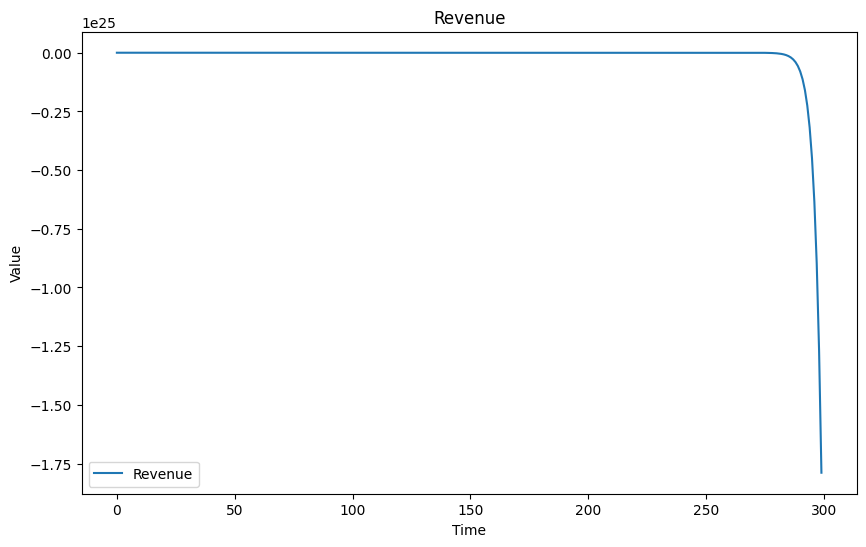

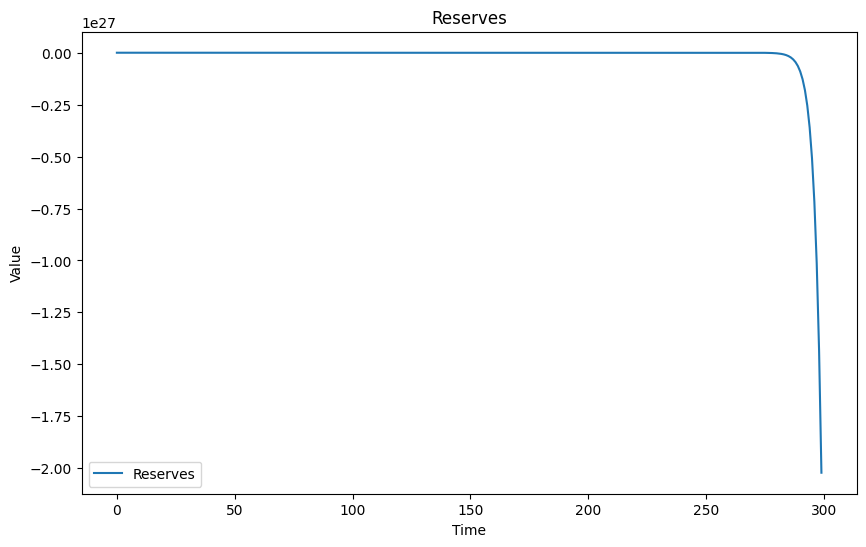

RuntimeError: `lowess=True` requires statsmodels, an optional dependency, to be installed.

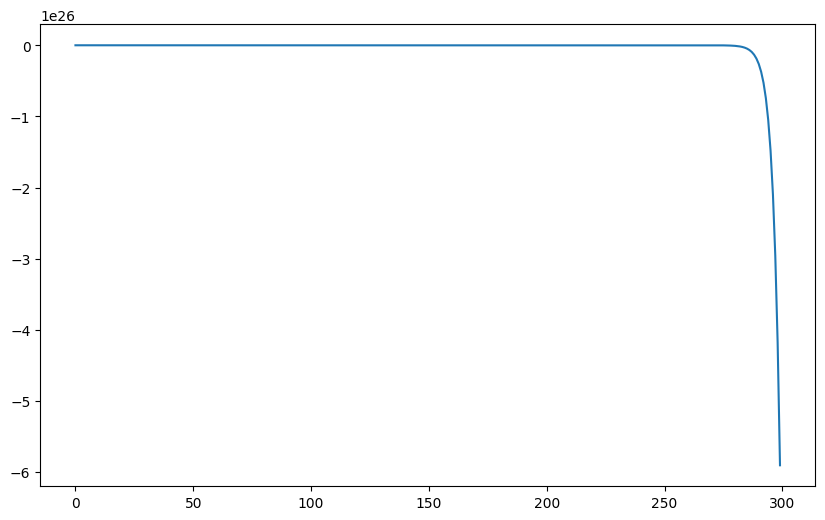

In [35]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.gridspec import GridSpec

# Convert the R data frames to pandas data frames
# Example data frames for banks, households, borrowers, and shocks
# Assuming `banks`, `households`, `borrowers` are dictionaries of dataframes

# Create the shocks dataframe
shocks_data = {
    'TF_shock': [PD_shock_TF, MRR_shock_TF, interest_shock_TF, spread_shock_TF, CAR_shock_TF],
    'when_shock': [p_change_PD, p_change_MRR, p_change_interest, p_change_spread, p_change_CAR]
}
shocks = pd.DataFrame(shocks_data)

which_shock = np.where([PD_shock_TF, MRR_shock_TF, interest_shock_TF, spread_shock_TF, CAR_shock_TF])[0]

# Plotting function
def plot_variable(data, title, y_label='Value', x_label='Time', vlines=None, smooth=False):
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['total'], label=title)
    if vlines is not None:
        for vline in vlines:
            plt.axvline(x=vline, linestyle='--', color='r', linewidth=1)
    if smooth:
        sns.regplot(x=data.index, y=data['total'], lowess=True, scatter_kws={'s': 0}, label='Trend')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

# Convert the data and plot
for key in banks.keys():
    banks[key] = pd.DataFrame(banks[key])

# Total Revenue
revenue = banks['revenue'].sum(axis=1).to_frame(name='total')
plot_variable(revenue, 'Revenue', vlines=shocks.loc[which_shock, 'when_shock'])

# Total Reserves
reserves = banks['reserves'].sum(axis=1).to_frame(name='total')
plot_variable(reserves, 'Reserves', vlines=shocks.loc[which_shock, 'when_shock'])

# Total Income
income = banks['income'].sum(axis=1).to_frame(name='total')
plot_variable(income, 'Income', vlines=shocks.loc[which_shock, 'when_shock'], smooth=True)

# Total Loans
loans = banks['loan_portfolio'].sum(axis=1).to_frame(name='total')
plot_variable(loans, 'Loans', vlines=shocks.loc[which_shock, 'when_shock'])

# Total Equity
equity = banks['equity'].sum(axis=1).to_frame(name='total')
plot_variable(equity, 'Equity', vlines=shocks.loc[which_shock, 'when_shock'])

# Profitability
profitability = (banks['income'] / banks['equity']).sum(axis=1).to_frame(name='total')
plot_variable(profitability, 'Profitability', vlines=shocks.loc[which_shock, 'when_shock'], smooth=True)

# Dividends
dividends = banks['dividends'].sum(axis=1).to_frame(name='total')
plot_variable(dividends, 'Dividends', vlines=shocks.loc[which_shock, 'when_shock'], smooth=True)

# Arrange plots in a grid
fig = plt.figure(constrained_layout=True, figsize=(15, 10))
gs = GridSpec(3, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])

def plot_variable_on_ax(ax, data, title, y_label='Value', x_label='Time', vlines=None, smooth=False):
    ax.plot(data.index, data['total'], label=title)
    if vlines is not None:
        for vline in vlines:
            ax.axvline(x=vline, linestyle='--', color='r', linewidth=1)
    if smooth:
        sns.regplot(x=data.index, y=data['total'], lowess=True, scatter_kws={'s': 0}, ax=ax, label='Trend')
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend()

plot_variable_on_ax(ax1, revenue, 'Revenue', vlines=shocks.loc[which_shock, 'when_shock'])
plot_variable_on_ax(ax2, reserves, 'Reserves', vlines=shocks.loc[which_shock, 'when_shock'])
plot_variable_on_ax(ax3, income, 'Income', vlines=shocks.loc[which_shock, 'when_shock'], smooth=True)
plot_variable_on_ax(ax4, loans, 'Loans', vlines=shocks.loc[which_shock, 'when_shock'])
plot_variable_on_ax(ax5, equity, 'Equity', vlines=shocks.loc[which_shock, 'when_shock'])
plot_variable_on_ax(ax6, profitability, 'Profitability', vlines=shocks.loc[which_shock, 'when_shock'], smooth=True)

plt.show()

# Checking for bankruptcies, liquidity assistance, and undercapitalized banks
any_bankruptcy = np.any(banks['bankruptcy'] == 1)
any_liquidity_assistance = np.any(banks['liquidity_assistance'] != 0)
any_undercapitalized = np.any(banks['undercapitalized'] == 1)

print(f"Any Bankruptcy: {any_bankruptcy}")
print(f"Any Liquidity Assistance: {any_liquidity_assistance}")
print(f"Any Undercapitalized: {any_undercapitalized}")

# Plot every bank's revenue separately
plt.figure(figsize=(12, 8))
for i in range(banks['revenue'].shape[1]):
    plt.plot(banks['revenue'].index, banks['revenue'].iloc[:, i], label=f'Bank {i+1}')
plt.title('Revenue of Each Bank')
plt.xlabel('Time')
plt.ylabel('Revenue')
plt.legend()
plt.show()


In [ ]:
'''
    # update reserves after decreasing equity by a dividend
    banks['reserves'][p, :] = banks['equity'][p, :] + banks['sum_deposits'][p, :] - banks['loan_portfolio'][p, :]
    
    ########### bankruptcy or undercapitalization check and liquidity assistance calculation ########
    
    # checking bankruptcy
    banks['bankruptcy'][p, :] = np.where(banks['equity'][p, :] <= 0, 1, 0)
    
    for k in np.where(banks['bankruptcy'][p, :] == 1)[0]:
        # leave negative equity for the rest of the simulation
        banks['equity'][p:t, k] = banks['equity'][p, k]
        
        # deleverage from deposits
        banks['sum_deposits'][p:t, k] = 0
        households['depo_value'][p, households['which_bank'][p, :] == k] = 0
        
        # fire-sell loans
        banks['loan_portfolio'][p:t, k] = 0
        borrowers['loan_value'][p, borrowers['which_bank'][p, :] == k] = 0
        
        # Check if there are non-bankrupt banks available
        non_bankrupt_banks = np.where(banks['bankruptcy'][p, :] == 0)[0]
        if len(non_bankrupt_banks) == 0:
            continue  # Skip if no non-bankrupt banks are available
        
        # allow other banks to give loans to its clients
        borrowers['which_bank'][p, borrowers['which_bank'][p, :] == k] = np.random.choice(
            non_bankrupt_banks,
            size=len(borrowers['which_bank'][p, borrowers['which_bank'][p, :] == k]),
            replace=True
        )
        
        # allow other banks to get deposits from its clients
        households['which_bank'][p, households['which_bank'][p, :] == k] = np.random.choice(
            non_bankrupt_banks,
            size=len(households['which_bank'][p, households['which_bank'][p, :] == k]),
            replace=True
        )
    
    # checking undercapitalization
    banks['undercapitalized'][p, :] = np.where(banks['equity'][p, :] < (banks['risk_weighted_assets'][p, :] * CAR[p]), 1, 0)
    
    for j in np.where(banks['undercapitalized'][p, :] == 1)[0]:
        if banks['bankruptcy'][p, j] == 1:
            continue
        
        liquidity_need = (banks['risk_weighted_assets'][p, j] * CAR[p]) - banks['equity'][p, j]
        banks['liquidity_assistance'][p, j] = liquidity_need
    
    ############# lending new loans ##########
    for h in np.where(banks['bankruptcy'][p] == 0)[0]:
        excess_reserves = banks['reserves'][p, h] - (banks['sum_deposits'][p, h] * MRR[p])
        excess_capital = (banks['equity'][p, h] - (banks['risk_weighted_assets'][p, h] * CAR[p])) / np.mean(borrowers['risk_weight'][p])
        
        # Check if excess_reserves or excess_capital is negative
        if excess_reserves < 0 or excess_capital < 0:
            continue  # Skip this bank if either excess_reserves or excess_capital is negative
            
        # Calculate potential_loans
        potential_loans = min(max(excess_reserves, 0), max(excess_capital, 0))
        
        # Check if potential_loans exceeds the available market
        available_market = len(borrowers['loan_value'][p][(borrowers['loan_value'][p] == 0) & (borrowers['which_bank'][p] == h)])
        if available_market < np.floor(potential_loans):
            potential_loans = available_market - 2
        
        # Ensure num_loans_to_give is non-negative
        num_loans_to_give = max(int(np.floor(potential_loans)), 0)
        
        # Create arrays of ones and zeros
        ones_array = np.ones(num_loans_to_give, dtype=int)
        zeros_array = np.zeros(max(available_market - num_loans_to_give, 0), dtype=int)
        
        # Concatenate arrays to match the size of the available market
        borrowers['loan_value'][p][(borrowers['loan_value'][p] == 0) & (borrowers['which_bank'][p] == h)] = np.concatenate((ones_array, zeros_array), axis=None)
        
        # Change loan portfolio
        banks['loan_portfolio'][p, h] = np.sum(borrowers['loan_value'][p][borrowers['which_bank'][p] == h])
        
    # Update reserves after increasing loans portfolio
    banks['reserves'][p] = banks['equity'][p] + banks['sum_deposits'][p] - banks['loan_portfolio'][p]

    # end of the progress bar
    percentage = p / t
    #setWinProgre
    '''

In [42]:
import numpy as np
import time

# Set initial values for banks
banks['income'][0, :] = 0
banks['reserves'][0, :] = banks['sum_deposits'][0, :] - banks['loan_portfolio'][0, :]

########### shocks ###########

# Probability of default shock
if PD_shock_TF:
    decrease_t = int(1 / PD_decrease_rate)  # how long will it take for shock to vanish
    nom_pd_decrease = max_PD_delta * PD_decrease_rate  # p.p decrease of the effect every period
    borrowers['pd'][p_change_PD, :] = borrowers['pd'][p_change_PD-1, :] + (max_PD_delta / 2)  # increase by half of the maximal delta at the beginning
    borrowers['pd'][p_change_PD:p_change_PD+decrease_t, :] = np.cumsum(np.concatenate(([max_PD_delta], np.repeat(-nom_pd_decrease, decrease_t))))  # add the effect.

# Capital adequacy requirements shock
if CAR_shock_TF:
    CAR[p_change_CAR:t] += CAR_delta

# Minimal reserve ratio shock
if MRR_shock_TF:
    MRR[p_change_MRR:t] += MRR_delta

# Interest rate shock
if interest_shock_TF:
    interest[p_change_interest:t] += interest_delta

########## start of the simulation #########

# progress bar and timer
# progress.bar <- winProgressBar("Simulating banking sector", "0% Done", 0, 1, 0)
ptm = time.process_time()

for p in range(1, t):

    ########### random change of the deposits ##########
    bank_change = np.zeros(households['which_bank'].shape[1])  # empty array

    # calculate the "safety effect" for a particular bank
    which_safe = np.where(banks['income'][p-1, :] < 0, safety_effect, 0)

    # generate randomly 1 or 0 given a withdrawal probability of a household
    households['which_bank'][p, :] = households['which_bank'][p-1, :]
    for u in range(n_households):
        current_bank = int(households['which_bank'][p, u])  # convert to integer
        withdrawal_prob_new = households['withdrawal_prob'][0, u] + which_safe[current_bank-1]  # add safety effect
        bank_change[u] = np.random.choice([1, 0], p=[withdrawal_prob_new, 1 - withdrawal_prob_new])

    # Get indices of non-bankrupt banks
    non_bankrupt_banks = np.where(banks['bankruptcy'][p-1, :] == 0)[0]

    # Check if there are any non-bankrupt banks
    if len(non_bankrupt_banks) > 0:
        change_indices = np.where(bank_change == 1)[0]
        if len(change_indices) > 0:
            new_banks = np.random.choice(
                non_bankrupt_banks,
                size=len(change_indices),
                replace=True
            )
            households['which_bank'][p, change_indices] = new_banks

    # change of the total deposits
    households['depo_value'][p, :] = households['depo_value'][p-1, :]
    for e in non_bankrupt_banks:
        banks['sum_deposits'][p, e] = np.sum(households['depo_value'][p, np.where(households['which_bank'][p, :] == e)[0]])

    
    ############ loan defaults ##########
    # same loan status as previous period
    borrowers['loan_value'][p, :] = borrowers['loan_value'][p-1, :]
    which_default = np.zeros(borrowers['loan_value'].shape[1])  # empty array

    # generate randomly 1 or 0 given a pd of a loan for every lended loan
    for i in np.where(borrowers['loan_value'][p, :] == 1)[0]:
        which_default[i] = np.random.choice([1, 0], p=[borrowers['pd'][p, i], 1 - borrowers['pd'][p, i]])

    # defaulted loans are no longer worth anything (except initial recovery, later on calculated)
    borrowers['loan_value'][p, np.where(which_default == 1)[0]] = 0

    # write-off loan defaults
    with_write_off = borrowers['loan_value'][p, :].copy()
    with_write_off[np.where(which_default == 1)[0]] = recovery_rate

    # calculating credit loss
    borrowers['which_bank'][p, :] = borrowers['which_bank'][p-1, :]
    for r in np.where(banks['bankruptcy'][p-1, :] == 0)[0]:
        banks['loan_portfolio'][p, r] = np.sum(with_write_off[np.where(borrowers['which_bank'][p, :] == r)[0]])

    loan_loss_t = banks['loan_portfolio'][p, :] - banks['loan_portfolio'][p-1, :]

    # updating expected loss provisions
    borrowers['recovery_rate'][p, :] = borrowers['recovery_rate'][p-1, :]
    for a in np.where(banks['bankruptcy'][p-1, :] == 0)[0]:
        indices = np.where(borrowers['which_bank'][p, :] == a)[0]
        banks['exp_loss_provision'][p, a] = np.sum(
            borrowers['pd'][p, indices] * borrowers['loan_value'][p, indices] * (1 - borrowers['recovery_rate'][p, indices])
        )

    ############ reserve check ##########
    # adjusting reserves to change in deposits
    banks['reserves'][p, :] = banks['sum_deposits'][p, :] - banks['loan_portfolio'][p, :] + banks['equity'][p-1, :]

    # which bank must sell loans because of the minimal reserves (1 if they fulfill the requirements, 0 otherwise)
    reserve_fullfill = np.where(banks['reserves'][p, :] < (banks['sum_deposits'][p, :] * MRR[p]), 0, 1)
    fire_sell_loss = np.zeros(n_banks)  # empty array for further PnL calculation

    for d in np.where(reserve_fullfill == 0)[0]:
        if banks['bankruptcy'][p-1, d] == 1:
            continue
        min_nr_loans_sell = int(np.ceil((banks['sum_deposits'][p, d] * MRR[p] - banks['reserves'][p, d]) / reserve_fire_sell))
        min_nr_loans_sell = min(min_nr_loans_sell, len(borrowers['loan_value'][p, (borrowers['which_bank'][p, :] == d) & (borrowers['loan_value'][p, :] == 1)]))  # Ensure no negative dimension
        fire_sell_loss[d] = np.ceil(banks['sum_deposits'][p, d] * MRR[p] - banks['reserves'][p, d]) * (1 - reserve_fire_sell)

        bank_loans = borrowers['loan_value'][p, (borrowers['which_bank'][p, :] == d) & (borrowers['loan_value'][p, :] == 1)]
        borrowers['loan_value'][p, (borrowers['which_bank'][p, :] == d) & (borrowers['loan_value'][p, :] == 1)] = np.concatenate(
            (np.ones(len(bank_loans) - min_nr_loans_sell, dtype=int), np.zeros(min_nr_loans_sell, dtype=int))
        )

    # repeating reserve calculation after adjusting
    banks['reserves'][p, :] = banks['sum_deposits'][p, :] - banks['loan_portfolio'][p, :] + banks['equity'][p-1, :]
    
    ########### calculating PnL and balance sheet ###############
    # changing spread (i.e. profitability of banks) given the consolidation/concentration of the market
    # depo_margin[p] = depo_margin[p] - concentration_spread((n_banks - np.sum(banks['bankruptcy'][p, :])) / n_banks)
    # loan_margin[p] = loan_margin[p] + concentration_spread((n_banks - np.sum(banks['bankruptcy'][p, :])) / n_banks)

    ## revenue of the bank
    # interest revenue
    for l in range(n_banks):
        if banks['bankruptcy'][p-1, l] == 1:
            continue
        indices = np.where(borrowers['which_bank'][p, :] == l)[0]
        banks['revenue'][p, l] = loan_margin[p] * np.sum(borrowers['loan_value'][p, indices])

    # interest on reserves at the central bank
    banks['revenue'][p, :] += banks['reserves'][p, :] * interest[p]

    ## cost of capital
    # interest on deposits
    for o in np.where(banks['bankruptcy'][p-1, :] == 0)[0]:
        banks['cost'][p, o] = depo_margin[p] * banks['sum_deposits'][p, o]

    ## profit and loss of the bank
    banks['pnl'][p, :] = banks['revenue'][p, :] - banks['cost'][p, :] - fire_sell_loss + loan_loss_t
    # calculating taxes and net profit
    banks['net_pnl'][p, :] = banks['pnl'][p, :] * (1 - tax_rate)

    ## dividends payment
    banks['retained_earnings'][p, :] = banks['net_pnl'][p, :]

    for s in np.where(banks['bankruptcy'][p-1, :] == 0)[0]:
        banks['equity'][p, s] = banks['equity'][p-1, s] + banks['retained_earnings'][p, s] - loan_loss_t[s] - fire_sell_loss[s]
        
        # Correcting max_dividend calculation to avoid negative values
        max_dividend = max(0, banks['equity'][p, s] - CAR[p] * banks['risk_weighted_assets'][p, s])
        
        dividend = min(max_dividend, retention_ratio * banks['net_pnl'][p, s])
        banks['dividends'][p, s] = max(0, dividend)  # Ensure dividend is not negative
        banks['equity'][p, s] -= banks['dividends'][p, s]
        banks['retained_earnings'][p, s] -= banks['dividends'][p, s]

    ############ Bank Defaults ##########
    banks['bankruptcy'][p, :] = np.where(
        (banks['reserves'][p, :] < (banks['sum_deposits'][p, :] * MRR[p])) |
        (banks['equity'][p, :] < (banks['risk_weighted_assets'][p, :] * CAR[p])), 1, 0
    )

    # final correction to avoid negatives
    banks['equity'][p, :] = np.maximum(banks['equity'][p, :], 0)
    banks['reserves'][p, :] = np.maximum(banks['reserves'][p, :], 0)

    # Displaying progress
    # info <- sprintf("%d%% done", round(p / t * 100))
    # setWinProgressBar(progress.bar, p / t, sprintf("Simulating banking sector (%s)", info), info)

time.process_time() - ptm
# Close progress bar
# close(progress.bar)


KeyError: 'pnl'

In [46]:
banks['equity']

,0,1,2,3,4,5,6,7,8,9
0,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
1,0.000000,14.469462,10.177816,9.619830,11.031330,11.734613,11.211717,10.805545,10.787889,9.185966
2,-0.051250,12.251933,9.909155,8.530569,9.710671,10.312119,9.473761,9.038357,10.385363,8.556147
3,-0.148141,11.982842,9.496594,7.543495,9.169899,8.755574,8.962080,8.302149,10.178199,7.314086
4,-0.253742,10.664446,8.644643,6.376310,8.732340,6.940387,8.233501,7.858544,9.959784,5.789477
...,...,...,...,...,...,...,...,...,...,...
295,-354.435884,-5107.398385,-10873.178577,-10715.463586,-3636.277140,-15473.661040,-3893.704214,-204.234691,-6853.566770,-11172.804024
296,-358.985082,-5173.759615,-11013.423310,-10853.739381,-3683.665604,-15673.213053,-3944.165517,-206.942625,-6942.438855,-11316.800324
297,-363.606146,-5240.977860,-11155.394851,-10993.674873,-3731.632674,-15875.246966,-3995.395086,-209.619407,-7032.401840,-11462.622828
298,-368.259973,-5309.011333,-11299.208537,-11135.435809,-3780.101832,-16079.847553,-4047.278774,-212.368400,-7123.425613,-11610.241864


In [43]:
import numpy as np

# Debugging Function
def debug_print(period, var_name, var):
    print(f"Period {period}: {var_name} = {var}")

# Loop through each period
for p in range(1, t):
    # ... [existing code] ...

    ########### calculating PnL and balance sheet ###############
    # changing spread (i.e. profitability of banks) given the consolidation/concentration of the market
    # depo_margin[p] = depo_margin[p] - concentration_spread((n_banks - np.sum(banks['bankruptcy'][p, :])) / n_banks)
    # loan_margin[p] = loan_margin[p] + concentration_spread((n_banks - np.sum(banks['bankruptcy'][p, :])) / n_banks)

    ## revenue of the bank
    # interest revenue
    for l in range(n_borrowers):
        borrowers['cost_capital'][p, l] = ((1 + ((loan_margin[p] + 1) * interest[p]) - borrowers['pd'][2, l] * borrowers['recovery_rate'][p, l]) /
                                          (1 - borrowers['pd'][2, l]))

    for y in np.where(banks['bankruptcy'][p-1, :] == 0)[0]:
        # cost of capital multiplied by loan value
        revenue_loop = np.sum(borrowers['cost_capital'][p-1, borrowers['which_bank'][p, :] == y] * 
                              borrowers['loan_value'][p, borrowers['which_bank'][p, :] == y]) - \
                       np.sum(borrowers['loan_value'][p, borrowers['which_bank'][p, :] == y])
        
        # adding interest from reserves invested during the previous period and minus fire sell 
        revenue_loop += banks['reserves'][p-1, y] * interest[p-1]
        banks['revenue'][p, y] = revenue_loop

    ## costs of the bank
    # deposit cost
    for f in np.where(banks['bankruptcy'][p-1, :] == 0)[0]:
        banks['cost'][p, f] = np.sum(households['depo_value'][p-1, households['which_bank'][p, :] == f] * interest[p] * (1 + depo_margin[p])) + \
                              fire_sell_loss[f]

    # liquidity assistance cost
    banks['cost'][p, :] += banks['liquidity_assistance'][p-1, :] * interest[p]

    # banks net income
    banks['income'][p, :] = (banks['revenue'][p, :] - banks['cost'][p, :]) + loan_loss_t - (banks['exp_loss_provision'][p-1, :] - banks['exp_loss_provision'][p, :]) - fire_sell_loss
    banks['equity'][p, :] = banks['equity'][p-1, :] + banks['income'][p, :]

    # dividends
    borrowers['risk_weight'][p, :] = risk_weight(borrowers['pd'][p, :])
    
    for g in np.where(banks['bankruptcy'][p-1, :] == 0)[0]:
        # a bank may give a dividend if the equity exceeds capital adequacy ratio by 1.5 its minimum
        banks['risk_weighted_assets'][p, g] = np.sum(borrowers['loan_value'][p, borrowers['which_bank'][p, :] == g] * 
                                                     borrowers['risk_weight'][p, borrowers['which_bank'][p, :] == g])
        max_dividend = banks['equity'][p, g] - banks['risk_weighted_assets'][p, g] * (CAR[p] * u_bound_CAR)
        debug_print(p, "max_dividend initial", max_dividend)

        # second requirement is bank may give dividend if the minimum reserve allows
        max_dividend_by_deposits = banks['reserves'][p, g] - (banks['sum_deposits'][p, g] * (MRR[p] * target_reserves))
        debug_print(p, "max_dividend_by_deposits", max_dividend_by_deposits)

        # if one of them don't allow to give dividends (i.e. 0) then give zero
        banks['dividends'][p, g] = max(min(max_dividend, max_dividend_by_deposits), 0)
        debug_print(p, "dividends", banks['dividends'][p, g])

        banks['equity'][p, g] -= banks['dividends'][p, g]
        debug_print(p, "equity after dividends", banks['equity'][p, g])

    # update reserves after decreasing equity by a dividend
    banks['reserves'][p, :] = banks['equity'][p, :] + banks['sum_deposits'][p, :] - banks['loan_portfolio'][p, :]
    debug_print(p, "reserves", banks['reserves'][p, :])

    ########### bankruptcy or undercapitalization check and liquidity assistance calculation ########

    # checking bankruptcy
    for k in np.where(banks['bankruptcy'][p, :] == 1)[0]:
        # leave negative equity for the rest of the simulation
        banks['equity'][p:t, k] = banks['equity'][p, k]

        # deleverage from deposits
        banks['sum_deposits'][p:t, k] = 0
        households['depo_value'][p, households['which_bank'][p, :] == k] = 0

        # fire-sell loans
        banks['loan_portfolio'][p:t, k] = 0
        borrowers['loan_value'][p, borrowers['which_bank'][p, :] == k] = 0

        # Check if there are non-bankrupt banks available
        non_bankrupt_banks = np.where(banks['bankruptcy'][p, :] == 0)[0]
        if len(non_bankrupt_banks) == 0:
            continue  # Skip if no non-bankrupt banks are available

        # allow other banks to give loans to its clients
        borrowers['which_bank'][p, borrowers['which_bank'][p, :] == k] = np.random.choice(
            non_bankrupt_banks,
            size=len(borrowers['which_bank'][p, borrowers['which_bank'][p, :] == k]),
            replace=True
        )

        # allow other banks to get deposits from its clients
        households['which_bank'][p, households['which_bank'][p, :] == k] = np.random.choice(
            non_bankrupt_banks,
            size=len(households['which_bank'][p, households['which_bank'][p, :] == k]),
            replace=True
        )

# Continue the remaining part of the loop...



Period 1: max_dividend initial = 39.89
Period 1: max_dividend_by_deposits = 47.44
Period 1: dividends = 39.89
Period 1: equity after dividends = 0.0
Period 1: max_dividend initial = 28.59388691608231
Period 1: max_dividend_by_deposits = 44.510000000000005
Period 1: dividends = 28.59388691608231
Period 1: equity after dividends = 14.469461902590027
Period 1: max_dividend initial = 29.18146154267569
Period 1: max_dividend_by_deposits = 46.47999999999999
Period 1: dividends = 29.18146154267569
Period 1: equity after dividends = 10.177816256578502
Period 1: max_dividend initial = 29.589650560411933
Period 1: max_dividend_by_deposits = 47.760000000000005
Period 1: dividends = 29.589650560411933
Period 1: equity after dividends = 9.619830355628736
Period 1: max_dividend initial = 31.42088085074512
Period 1: max_dividend_by_deposits = 36.500000000000014
Period 1: dividends = 31.42088085074512
Period 1: equity after dividends = 11.031330156531425
Period 1: max_dividend initial = 26.39608952307

In [44]:
max_dividend

-11759.649887058264

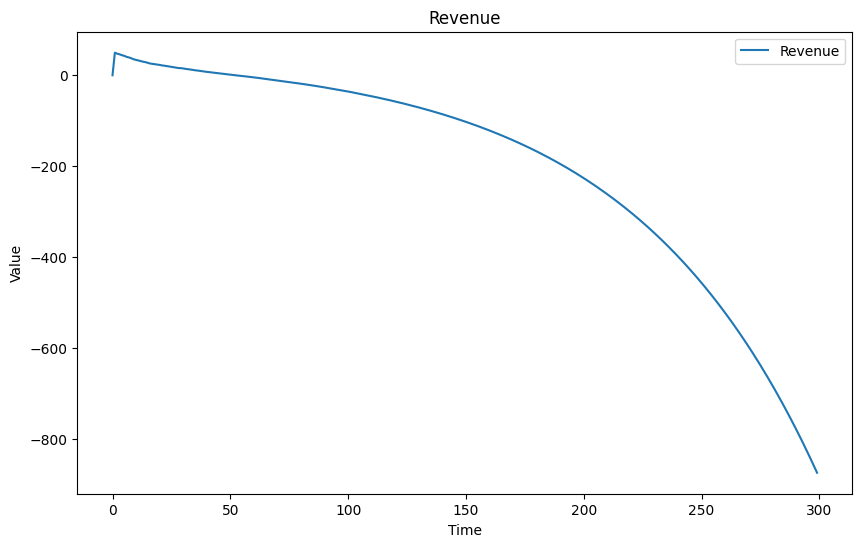

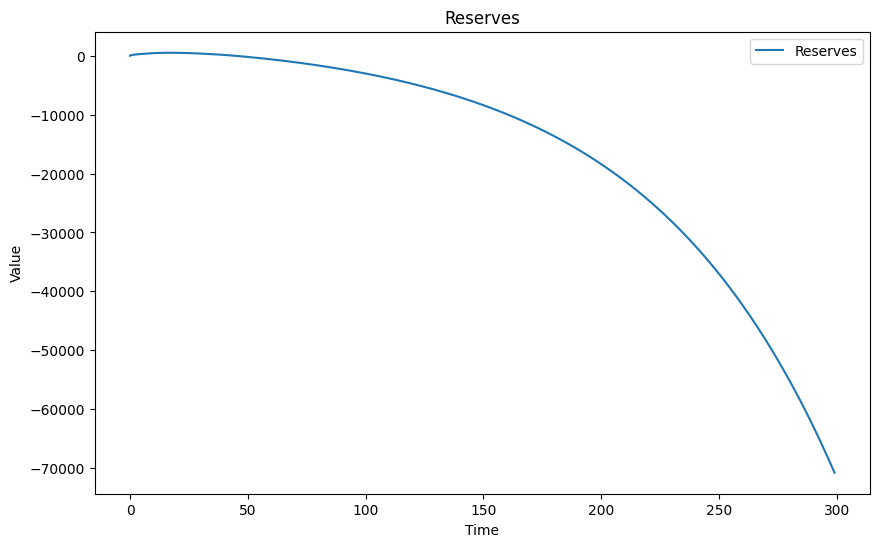

RuntimeError: `lowess=True` requires statsmodels, an optional dependency, to be installed.

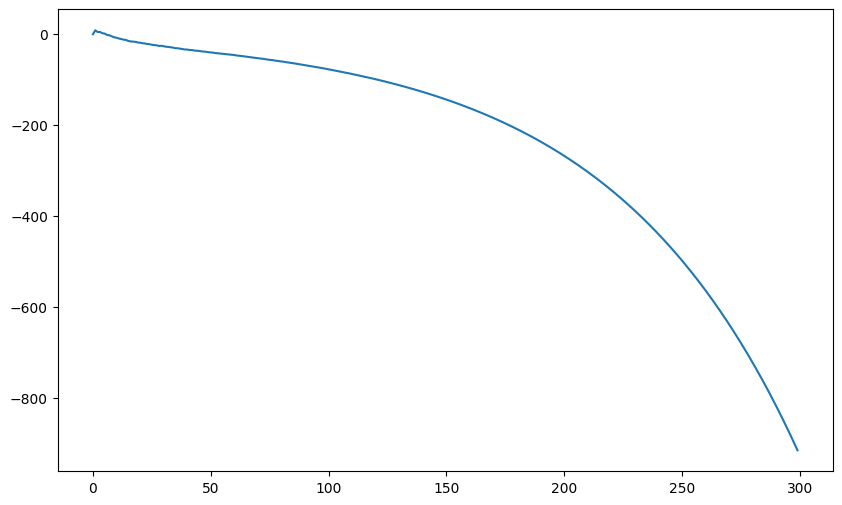

In [45]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.gridspec import GridSpec

# Convert the R data frames to pandas data frames
# Example data frames for banks, households, borrowers, and shocks
# Assuming `banks`, `households`, `borrowers` are dictionaries of dataframes

# Create the shocks dataframe
shocks_data = {
    'TF_shock': [PD_shock_TF, MRR_shock_TF, interest_shock_TF, spread_shock_TF, CAR_shock_TF],
    'when_shock': [p_change_PD, p_change_MRR, p_change_interest, p_change_spread, p_change_CAR]
}
shocks = pd.DataFrame(shocks_data)

which_shock = np.where([PD_shock_TF, MRR_shock_TF, interest_shock_TF, spread_shock_TF, CAR_shock_TF])[0]

# Plotting function
def plot_variable(data, title, y_label='Value', x_label='Time', vlines=None, smooth=False):
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['total'], label=title)
    if vlines is not None:
        for vline in vlines:
            plt.axvline(x=vline, linestyle='--', color='r', linewidth=1)
    if smooth:
        sns.regplot(x=data.index, y=data['total'], lowess=True, scatter_kws={'s': 0}, label='Trend')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

# Convert the data and plot
for key in banks.keys():
    banks[key] = pd.DataFrame(banks[key])

# Total Revenue
revenue = banks['revenue'].sum(axis=1).to_frame(name='total')
plot_variable(revenue, 'Revenue', vlines=shocks.loc[which_shock, 'when_shock'])

# Total Reserves
reserves = banks['reserves'].sum(axis=1).to_frame(name='total')
plot_variable(reserves, 'Reserves', vlines=shocks.loc[which_shock, 'when_shock'])

# Total Income
income = banks['income'].sum(axis=1).to_frame(name='total')
plot_variable(income, 'Income', vlines=shocks.loc[which_shock, 'when_shock'], smooth=True)

# Total Loans
loans = banks['loan_portfolio'].sum(axis=1).to_frame(name='total')
plot_variable(loans, 'Loans', vlines=shocks.loc[which_shock, 'when_shock'])

# Total Equity
equity = banks['equity'].sum(axis=1).to_frame(name='total')
plot_variable(equity, 'Equity', vlines=shocks.loc[which_shock, 'when_shock'])

# Profitability
profitability = (banks['income'] / banks['equity']).sum(axis=1).to_frame(name='total')
plot_variable(profitability, 'Profitability', vlines=shocks.loc[which_shock, 'when_shock'], smooth=True)

# Dividends
dividends = banks['dividends'].sum(axis=1).to_frame(name='total')
plot_variable(dividends, 'Dividends', vlines=shocks.loc[which_shock, 'when_shock'], smooth=True)

# Arrange plots in a grid
fig = plt.figure(constrained_layout=True, figsize=(15, 10))
gs = GridSpec(3, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])

def plot_variable_on_ax(ax, data, title, y_label='Value', x_label='Time', vlines=None, smooth=False):
    ax.plot(data.index, data['total'], label=title)
    if vlines is not None:
        for vline in vlines:
            ax.axvline(x=vline, linestyle='--', color='r', linewidth=1)
    if smooth:
        sns.regplot(x=data.index, y=data['total'], lowess=True, scatter_kws={'s': 0}, ax=ax, label='Trend')
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend()

plot_variable_on_ax(ax1, revenue, 'Revenue', vlines=shocks.loc[which_shock, 'when_shock'])
plot_variable_on_ax(ax2, reserves, 'Reserves', vlines=shocks.loc[which_shock, 'when_shock'])
plot_variable_on_ax(ax3, income, 'Income', vlines=shocks.loc[which_shock, 'when_shock'], smooth=True)
plot_variable_on_ax(ax4, loans, 'Loans', vlines=shocks.loc[which_shock, 'when_shock'])
plot_variable_on_ax(ax5, equity, 'Equity', vlines=shocks.loc[which_shock, 'when_shock'])
plot_variable_on_ax(ax6, profitability, 'Profitability', vlines=shocks.loc[which_shock, 'when_shock'], smooth=True)

plt.show()

# Checking for bankruptcies, liquidity assistance, and undercapitalized banks
any_bankruptcy = np.any(banks['bankruptcy'] == 1)
any_liquidity_assistance = np.any(banks['liquidity_assistance'] != 0)
any_undercapitalized = np.any(banks['undercapitalized'] == 1)

print(f"Any Bankruptcy: {any_bankruptcy}")
print(f"Any Liquidity Assistance: {any_liquidity_assistance}")
print(f"Any Undercapitalized: {any_undercapitalized}")

# Plot every bank's revenue separately
plt.figure(figsize=(12, 8))
for i in range(banks['revenue'].shape[1]):
    plt.plot(banks['revenue'].index, banks['revenue'].iloc[:, i], label=f'Bank {i+1}')
plt.title('Revenue of Each Bank')
plt.xlabel('Time')
plt.ylabel('Revenue')
plt.legend()
plt.show()


In [93]:

import numpy as np

# Parameters
t = 300  # how long will simulation take
n_banks = 10  # number of bank agents
n_households = 1000  # number of household agents (gives deposits)
n_borrowers = 2000  # number of borrower agents (take loans)
loan_periods = 1
equity = 40  # starting equity for each bank
interest = 0.0125  # interest
CAR = 0.08  # capital adequacy ratio
MRR = 0.035  # minimal reserve ratio
depo_margin = 0.1  # margin for the deposits. (1 + depo_margin) X interest
loan_margin = 0.9  # calculated same as depo_margin
recovery_rate = 0.4  # how much will bank get from default loans
withdrawal_prob_min = 0.01  # minimum probability for household to change bank
withdrawal_prob_max = 0.08  # maximum probability
default_prob_min = 0.04  # minimal probability for a loan to default during 1 period
default_prob_max = 0.08  # maximal
reserve_fire_sell = 0.8  # for how much of a face value will bank sell loan when in need of liquidity to satisfy reserves
bankruptcy_fire_sell = 0.5  # for how much will bank sell loans when go bankrupt
income_tax = 0.18  # tax
target_reserves = 2  # multiplier to MRR for optimal reserves held
u_bound_CAR = 2  # multiplier to CAR for optimal capital adequacy held
safety_effect = 0.04

#%%
# Functions
def risk_weight(x):
    return 0.5 + 5 * x  # how is risk weight of a loan calculated. x is PD


def concentration_spread(x):
    return 0.15 * x ** 2  # less competition - bigger spread. To give additional spread at the start add intercept to the function

#%%
# Shocks variables
CAR_shock_TF = False
p_change_CAR = 40  # period of change
CAR_delta = 0.02

PD_shock_TF = False
p_change_PD = 30
max_PD_delta = 0.07
PD_decrease_rate = 0.05

MRR_shock_TF = False
p_change_MRR = 50
MRR_delta = 0.03

interest_shock_TF = False
p_change_interest = 50
interest_delta = 0.005

spread_shock_TF = False
p_change_spread = 50
l_margin_delta = 0.02
d_margin_delta = -0.01
#%%%

# Agent matrices
# Initialize banks, borrowers, and households dictionaries with appropriate sizes and data
households = {
    "depo_value": np.zeros((t, n_households)),
    "which_bank": np.zeros((t, n_households)),
    "withdrawal_prob": np.zeros((t, n_households))
}

borrowers = {
    "loan_value": np.zeros((t, n_borrowers)),
    "which_bank": np.zeros((t, n_borrowers)),
    "pd": np.zeros((t, n_borrowers)),
    "recovery_rate": np.zeros((t, n_borrowers)),
    "cost_capital": np.zeros((t, n_borrowers)),
    "risk_weight": np.zeros((t, n_borrowers)),
    "loan_end": np.zeros((t, n_borrowers))
}

banks = {
    "equity": np.zeros((t, n_banks)),
    "sum_deposits": np.zeros((t, n_banks)),
    "loan_portfolio": np.zeros((t, n_banks)),
    "reserves": np.zeros((t, n_banks)),
    "exp_loss_provision": np.zeros((t, n_banks)),
    "revenue": np.zeros((t, n_banks)),
    "cost": np.zeros((t, n_banks)),
    "income": np.zeros((t, n_banks)),
    "interbank_given": np.zeros((t, n_banks)),
    "interbank_taken": np.zeros((t, n_banks)),
    "interbank_from": np.zeros((t, n_banks)),
    "interbank_to": np.zeros((t, n_banks)),
    "risk_weighted_assets": np.zeros((t, n_banks)),
    "dividends": np.zeros((t, n_banks)),
    "liquidity_assistance": np.zeros((t, n_banks)),
    "bankruptcy": np.zeros((t, n_banks)),
    "undercapitalized": np.zeros((t, n_banks))
}
#%%


#%%
# changing to a time series for incorporating exogenous shocks later on
CAR = np.repeat(CAR, t)
MRR = np.repeat(MRR, t)
interest = np.repeat(interest, t)
depo_margin = np.repeat(depo_margin, t)
loan_margin = np.repeat(loan_margin, t)


#%%



#%%


# Set initial values for households
households['depo_value'][0, :] = 1
households['which_bank'][0, :] = np.random.choice(np.arange(1, n_banks + 1), size=n_households, replace=True)
households['withdrawal_prob'][0, :] = np.random.uniform(withdrawal_prob_min, withdrawal_prob_max, size=n_households)

# Copy withdrawal probabilities from the first row to subsequent rows
for o in range(1, t):
    households['withdrawal_prob'][o, :] = households['withdrawal_prob'][0, :]
    
    
#%%
# Set initial values for borrowers
borrowers["pd"] = np.random.uniform(default_prob_min, default_prob_max, size=(t, n_borrowers))
borrowers["recovery_rate"][0, :] = recovery_rate
borrowers["risk_weight"][0, :] = risk_weight(borrowers["pd"][0, :])
borrowers["which_bank"][0, :] = np.random.choice(np.arange(1, n_banks+1), size=n_borrowers, replace=True)
borrowers["loan_end"][0, :] = np.random.choice(np.arange(1, loan_periods+1), size=n_borrowers, replace=True)

# Calculate initial cost of capital
for q in range(n_borrowers):
    borrowers["cost_capital"][0, q] = (1 + ((loan_margin[0] + 1) * interest[0]) - borrowers["pd"][0, q] * borrowers["recovery_rate"][0, q]) / (1 - borrowers["pd"][0, q])


#%%

# Set initial values for banks
banks["equity"][0, :] = equity

for w in range(n_banks):
    # Sum deposits
    banks['sum_deposits'][0, w] = np.sum(households['depo_value'][0, households['which_bank'][0,] == w])
    
    # Initialize loan portfolio that is in line with regulations
    # Total of risk weighted assets on the market for a given bank
    RW_assets = borrowers['risk_weight'][0, borrowers['which_bank'][0,] == w]
    
    # Potential number of loans that the bank have deposits to lend with reserve
    potential_share_of_market_reserves = banks['sum_deposits'][0, w] * (1 - MRR[0])
    
    # Potential number of loans that will be in line with regulations 
    cumulative_risk_weighted_assets = np.cumsum(RW_assets * CAR[0])
    potential_share_of_market = np.sum(cumulative_risk_weighted_assets < banks['equity'][0, w])
    
    # Number loans that fulfill two requirements (reserves and capital requirements)
    potential_loans = int(np.floor(min(potential_share_of_market_reserves, potential_share_of_market)))
    
    # Give loans to those borrowers minus some margin for safety
    loan_indices = np.where(borrowers['which_bank'][0,] == w)[0]
    num_loans = len(loan_indices)
    loan_values = np.zeros(num_loans, dtype=int)
    loan_values[:(potential_loans - 5)] = 1
    np.random.shuffle(loan_values)
    
    borrowers['loan_value'][0, loan_indices] = loan_values
    
    # Sum of the loans
    banks['loan_portfolio'][0, w] = np.sum(borrowers['loan_value'][0, loan_indices])
    
    # Calculate risk weighted assets
    banks['risk_weighted_assets'][0, w] = np.sum(borrowers['risk_weight'][0, loan_indices] * borrowers['loan_value'][0, loan_indices])
    
    # Expected loss provisions
    banks['exp_loss_provision'][0, w] = np.sum(borrowers['pd'][0, loan_indices] * borrowers['loan_value'][0, loan_indices] * (1 - borrowers['recovery_rate'][0, loan_indices]))


#%%

 
    
# Calculate income and reserves
banks["income"][0, :] = 0
banks["reserves"][0, :] = banks["sum_deposits"][0, :] - banks["loan_portfolio"][0, :]


#%%

import numpy as np
import time
# Set initial values for banks
banks['income'][0, :] = 0
banks['reserves'][0, :] = banks['sum_deposits'][0, :] - banks['loan_portfolio'][0, :]

########### shocks ###########

# Probability of default shock
if PD_shock_TF:
    decrease_t = int(1 / PD_decrease_rate)  # how long will it take for shock to vanish
    nom_pd_decrease = max_PD_delta * PD_decrease_rate  # p.p decrease of the effect every period
    borrowers['pd'][p_change_PD, :] = borrowers['pd'][p_change_PD-1, :] + (max_PD_delta / 2)  # increase by half of the maximal delta at the beginning
    borrowers['pd'][p_change_PD:p_change_PD+decrease_t, :] = np.cumsum(np.concatenate(([max_PD_delta], np.repeat(-nom_pd_decrease, decrease_t))))  # add the effect.

# Capital adequacy requirements shock
if CAR_shock_TF:
    CAR[p_change_CAR:t] += CAR_delta

# Minimal reserve ratio shock
if MRR_shock_TF:
    MRR[p_change_MRR:t] += MRR_delta

# Interest rate shock
if interest_shock_TF:
    interest[p_change_interest:t] += interest_delta

########## start of the simulation #########

# progress bar and timer
# progress.bar <- winProgressBar("Simulating banking sector", "0% Done", 0, 1, 0)
ptm = time.process_time()


# Debugging Function
def debug_print(period, var_name, var):
    print(f"Period {period}: {var_name} = {var}")

def random_change_of_deposits(households, banks, withdrawal_prob_new):
    bank_change = np.zeros(households['which_bank'].shape[1])  # empty array

    # calculate the "safety effect" for a particular bank
    #which_safe = np.where(banks['income'][p-1, :] < 0, safety_effect, 0)

    # generate randomly 1 or 0 given a withdrawal probability of a household
    households['which_bank'][p, :] = households['which_bank'][p-1, :]
    for u in range(n_households):
        current_bank = int(households['which_bank'][p, u])  # convert to integer
        withdrawal_prob_new = households['withdrawal_prob'][0, u]# + which_safe[current_bank-1]  # add safety effect
        bank_change[u] = np.random.choice([1, 0], p=[withdrawal_prob_new, 1 - withdrawal_prob_new])

    # Get indices of non-bankrupt banks
    non_bankrupt_banks = np.where(banks['bankruptcy'][p-1, :] == 0)[0]

    # Check if there are any non-bankrupt banks
    if len(non_bankrupt_banks) > 0:
        change_indices = np.where(bank_change == 1)[0] #indices of banks where change occurs
        if len(change_indices) > 0: #if those banks that change
            new_banks = np.random.choice(
                non_bankrupt_banks,
                size=len(change_indices),
                replace=True
            )
            households['which_bank'][p, change_indices] = new_banks
    return households 

# Loop through each period
for p in range(1, t):
    # ... [existing code] ...
    
    ########### random change of the deposits ##########
    bank_change = np.zeros(households['which_bank'].shape[1])  # empty array

    # calculate the "safety effect" for a particular bank
    #which_safe = np.where(banks['income'][p-1, :] < 0, safety_effect, 0)

    # generate randomly 1 or 0 given a withdrawal probability of a household
    households['which_bank'][p, :] = households['which_bank'][p-1, :]
    for u in range(n_households):
        current_bank = int(households['which_bank'][p, u])  # convert to integer
        withdrawal_prob_new = households['withdrawal_prob'][0, u]# + which_safe[current_bank-1]  # add safety effect
        bank_change[u] = np.random.choice([1, 0], p=[withdrawal_prob_new, 1 - withdrawal_prob_new])

    # Get indices of non-bankrupt banks
    non_bankrupt_banks = np.where(banks['bankruptcy'][p-1, :] == 0)[0]

    # Check if there are any non-bankrupt banks
    if len(non_bankrupt_banks) > 0:
        change_indices = np.where(bank_change == 1)[0]
        if len(change_indices) > 0:
            new_banks = np.random.choice(
                non_bankrupt_banks,
                size=len(change_indices),
                replace=True
            )
            households['which_bank'][p, change_indices] = new_banks

    # change of the total deposits
    households['depo_value'][p, :] = households['depo_value'][p-1, :]
    for e in non_bankrupt_banks:
        banks['sum_deposits'][p, e] = np.sum(households['depo_value'][p, np.where(households['which_bank'][p, :] == e)[0]])

    
    ############ loan defaults ##########
    # same loan status as previous period
    borrowers['loan_value'][p, :] = borrowers['loan_value'][p-1, :]
    which_default = np.zeros(borrowers['loan_value'].shape[1])  # empty array

    # generate randomly 1 or 0 given a pd of a loan for every lended loan
    for i in np.where(borrowers['loan_value'][p, :] == 1)[0]:
        which_default[i] = np.random.choice([1, 0], p=[borrowers['pd'][p, i], 1 - borrowers['pd'][p, i]])

    # defaulted loans are no longer worth anything (except initial recovery, later on calculated)
    borrowers['loan_value'][p, np.where(which_default == 1)[0]] = 0

    # write-off loan defaults
    with_write_off = borrowers['loan_value'][p, :].copy()
    with_write_off[np.where(which_default == 1)[0]] = recovery_rate

    # calculating credit loss
    borrowers['which_bank'][p, :] = borrowers['which_bank'][p-1, :]
    for r in np.where(banks['bankruptcy'][p-1, :] == 0)[0]:
        banks['loan_portfolio'][p, r] = np.sum(with_write_off[np.where(borrowers['which_bank'][p, :] == r)[0]])

    loan_loss_t = banks['loan_portfolio'][p, :] - banks['loan_portfolio'][p-1, :]

    # updating expected loss provisions
    borrowers['recovery_rate'][p, :] = borrowers['recovery_rate'][p-1, :]
    for a in np.where(banks['bankruptcy'][p-1, :] == 0)[0]:
        indices = np.where(borrowers['which_bank'][p, :] == a)[0]
        banks['exp_loss_provision'][p, a] = np.sum(
            borrowers['pd'][p, indices] * borrowers['loan_value'][p, indices] * (1 - borrowers['recovery_rate'][p, indices])
        )

    ############ reserve check ##########
    # adjusting reserves to change in deposits
    banks['reserves'][p, :] = banks['sum_deposits'][p, :] - banks['loan_portfolio'][p, :] + banks['equity'][p-1, :]

    # which bank must sell loans because of the minimal reserves (1 if they fulfill the requirements, 0 otherwise)
    reserve_fullfill = np.where(banks['reserves'][p, :] < (banks['sum_deposits'][p, :] * MRR[p]), 0, 1)
    fire_sell_loss = np.zeros(n_banks)  # empty array for further PnL calculation

    for d in np.where(reserve_fullfill == 0)[0]:
        if banks['bankruptcy'][p-1, d] == 1:
            continue
        min_nr_loans_sell = int(np.ceil((banks['sum_deposits'][p, d] * MRR[p] - banks['reserves'][p, d]) / reserve_fire_sell))
        min_nr_loans_sell = min(min_nr_loans_sell, len(borrowers['loan_value'][p, (borrowers['which_bank'][p, :] == d) & (borrowers['loan_value'][p, :] == 1)]))  # Ensure no negative dimension
        fire_sell_loss[d] = np.ceil(banks['sum_deposits'][p, d] * MRR[p] - banks['reserves'][p, d]) * (1 - reserve_fire_sell)

        bank_loans = borrowers['loan_value'][p, (borrowers['which_bank'][p, :] == d) & (borrowers['loan_value'][p, :] == 1)]
        borrowers['loan_value'][p, (borrowers['which_bank'][p, :] == d) & (borrowers['loan_value'][p, :] == 1)] = np.concatenate(
            (np.ones(len(bank_loans) - min_nr_loans_sell, dtype=int), np.zeros(min_nr_loans_sell, dtype=int))
        )

    # repeating reserve calculation after adjusting
    banks['reserves'][p, :] = banks['sum_deposits'][p, :] - banks['loan_portfolio'][p, :] + banks['equity'][p-1, :]
  
    ########### calculating PnL and balance sheet ###############
    # changing spread (i.e. profitability of banks) given the consolidation/concentration of the market
    # depo_margin[p] = depo_margin[p] - concentration_spread((n_banks - np.sum(banks['bankruptcy'][p, :])) / n_banks)
    # loan_margin[p] = loan_margin[p] + concentration_spread((n_banks - np.sum(banks['bankruptcy'][p, :])) / n_banks)

    ## revenue of the bank
    # interest revenue
    for l in range(n_borrowers):
        borrowers['cost_capital'][p, l] = ((1 + ((loan_margin[p] + 1) * interest[p]) - borrowers['pd'][2, l] * borrowers['recovery_rate'][p, l]) /
                                          (1 - borrowers['pd'][2, l]))

    for y in np.where(banks['bankruptcy'][p-1, :] == 0)[0]:
        # cost of capital multiplied by loan value
        revenue_loop = np.sum(borrowers['cost_capital'][p-1, borrowers['which_bank'][p, :] == y] * 
                              borrowers['loan_value'][p, borrowers['which_bank'][p, :] == y]) - \
                       np.sum(borrowers['loan_value'][p, borrowers['which_bank'][p, :] == y])
        
        # adding interest from reserves invested during the previous period and minus fire sell 
        revenue_loop += banks['reserves'][p-1, y] * interest[p-1]
        banks['revenue'][p, y] = revenue_loop

    ## costs of the bank
    # deposit cost
    for f in np.where(banks['bankruptcy'][p-1, :] == 0)[0]:
        banks['cost'][p, f] = np.sum(households['depo_value'][p-1, households['which_bank'][p, :] == f] * interest[p] * (1 + depo_margin[p])) + \
                              fire_sell_loss[f]

    # liquidity assistance cost
    banks['cost'][p, :] += banks['liquidity_assistance'][p-1, :] * interest[p]

    # banks net income
    banks['income'][p, :] = (banks['revenue'][p, :] - banks['cost'][p, :]) + loan_loss_t - (banks['exp_loss_provision'][p-1, :] - banks['exp_loss_provision'][p, :]) - fire_sell_loss
    banks['equity'][p, :] = banks['equity'][p-1, :] + banks['income'][p, :]

    # dividends
    borrowers['risk_weight'][p, :] = risk_weight(borrowers['pd'][p, :])
    
    for g in np.where(banks['bankruptcy'][p-1, :] == 0)[0]:
        # a bank may give a dividend if the equity exceeds capital adequacy ratio by 1.5 its minimum
        banks['risk_weighted_assets'][p, g] = np.sum(borrowers['loan_value'][p, borrowers['which_bank'][p, :] == g] * 
                                                     borrowers['risk_weight'][p, borrowers['which_bank'][p, :] == g])
        max_dividend = banks['equity'][p, g] - banks['risk_weighted_assets'][p, g] * (CAR[p] * u_bound_CAR)
        #debug_print(p, "max_dividend initial", max_dividend)

        # second requirement is bank may give dividend if the minimum reserve allows
        max_dividend_by_deposits = banks['reserves'][p, g] - (banks['sum_deposits'][p, g] * (MRR[p] * target_reserves))
        #debug_print(p, "max_dividend_by_deposits", max_dividend_by_deposits)

        # if one of them don't allow to give dividends (i.e. 0) then give zero
        banks['dividends'][p, g] = max(min(max_dividend, max_dividend_by_deposits), 0)
        #debug_print(p, "dividends", banks['dividends'][p, g])

        banks['equity'][p, g] -= banks['dividends'][p, g]
        #debug_print(p, "equity after dividends", banks['equity'][p, g])

    # update reserves after decreasing equity by a dividend
    banks['reserves'][p, :] = banks['equity'][p, :] + banks['sum_deposits'][p, :] - banks['loan_portfolio'][p, :]
    #debug_print(p, "reserves", banks['reserves'][p, :])

    ########### bankruptcy or undercapitalization check and liquidity assistance calculation ########

    # checking bankruptcy
    for k in np.where(banks['bankruptcy'][p, :] == 1)[0]:
        # leave negative equity for the rest of the simulation
        banks['equity'][p:t, k] = banks['equity'][p, k]

        # deleverage from deposits
        banks['sum_deposits'][p:t, k] = 0
        households['depo_value'][p, households['which_bank'][p, :] == k] = 0

        # fire-sell loans
        banks['loan_portfolio'][p:t, k] = 0
        borrowers['loan_value'][p, borrowers['which_bank'][p, :] == k] = 0

        # Check if there are non-bankrupt banks available
        non_bankrupt_banks = np.where(banks['bankruptcy'][p, :] == 0)[0]
        if len(non_bankrupt_banks) == 0:
            continue  # Skip if no non-bankrupt banks are available

        # allow other banks to give loans to its clients
        borrowers['which_bank'][p, borrowers['which_bank'][p, :] == k] = np.random.choice(
            non_bankrupt_banks,
            size=len(borrowers['which_bank'][p, borrowers['which_bank'][p, :] == k]),
            replace=True
        )

        # allow other banks to get deposits from its clients
        households['which_bank'][p, households['which_bank'][p, :] == k] = np.random.choice(
            non_bankrupt_banks,
            size=len(households['which_bank'][p, households['which_bank'][p, :] == k]),
            replace=True
        )

# Continue the remaining part of the loop...



In [94]:
banks['equity']

array([[ 4.00000000e+01,  4.00000000e+01,  4.00000000e+01, ...,
         4.00000000e+01,  4.00000000e+01,  4.00000000e+01],
       [ 0.00000000e+00,  1.23959503e+01,  1.05505468e+01, ...,
         1.29766078e+01,  1.09405333e+01,  1.12412695e+01],
       [-7.00000000e-02,  1.19182990e+01,  9.92868407e+00, ...,
         1.21654920e+01,  9.99477706e+00,  1.06420984e+01],
       ...,
       [-1.20115033e+16, -4.22584130e+26, -3.82292156e+24, ...,
        -6.76573625e+28, -7.81253968e+26, -2.08094241e+20],
       [-1.69662484e+16, -5.96900083e+26, -5.39987670e+24, ...,
        -9.55660245e+28, -1.10352123e+27, -2.93933115e+20],
       [-2.39648259e+16, -8.43121368e+26, -7.62732584e+24, ...,
        -1.34987010e+29, -1.55872374e+27, -4.15180525e+20]])

In [95]:
reserve_fullfill

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [107]:

import numpy as np

# Parameters
t = 300  # how long will simulation take
n_banks = 10  # number of bank agents
n_households = 1000  # number of household agents (gives deposits)
n_borrowers = 2000  # number of borrower agents (take loans)
loan_periods = 1
equity = 40  # starting equity for each bank
interest = 0.0125  # interest
CAR = 0.08  # capital adequacy ratio
MRR = 0.035  # minimal reserve ratio
depo_margin = 0.1  # margin for the deposits. (1 + depo_margin) X interest
loan_margin = 0.9  # calculated same as depo_margin
recovery_rate = 0.4  # how much will bank get from default loans
withdrawal_prob_min = 0.01  # minimum probability for household to change bank
withdrawal_prob_max = 0.08  # maximum probability
default_prob_min = 0.04  # minimal probability for a loan to default during 1 period
default_prob_max = 0.08  # maximal
reserve_fire_sell = 0.8  # for how much of a face value will bank sell loan when in need of liquidity to satisfy reserves
bankruptcy_fire_sell = 0.5  # for how much will bank sell loans when go bankrupt
income_tax = 0.18  # tax
target_reserves = 2  # multiplier to MRR for optimal reserves held
u_bound_CAR = 2  # multiplier to CAR for optimal capital adequacy held
safety_effect = 0.04

#%%
# Functions
def risk_weight(x):
    return 0.5 + 5 * x  # how is risk weight of a loan calculated. x is PD


def concentration_spread(x):
    return 0.15 * x ** 2  # less competition - bigger spread. To give additional spread at the start add intercept to the function

#%%
# Shocks variables
CAR_shock_TF = False
p_change_CAR = 40  # period of change
CAR_delta = 0.02

PD_shock_TF = False
p_change_PD = 30
max_PD_delta = 0.07
PD_decrease_rate = 0.05

MRR_shock_TF = False
p_change_MRR = 50
MRR_delta = 0.03

interest_shock_TF = False
p_change_interest = 50
interest_delta = 0.005

spread_shock_TF = False
p_change_spread = 50
l_margin_delta = 0.02
d_margin_delta = -0.01
#%%%

# Agent matrices
# Initialize banks, borrowers, and households dictionaries with appropriate sizes and data
households = {
    "depo_value": np.zeros((t, n_households)),
    "which_bank": np.zeros((t, n_households)),
    "withdrawal_prob": np.zeros((t, n_households))
}

borrowers = {
    "loan_value": np.zeros((t, n_borrowers)),
    "which_bank": np.zeros((t, n_borrowers)),
    "pd": np.zeros((t, n_borrowers)),
    "recovery_rate": np.zeros((t, n_borrowers)),
    "cost_capital": np.zeros((t, n_borrowers)),
    "risk_weight": np.zeros((t, n_borrowers)),
    "loan_end": np.zeros((t, n_borrowers))
}

banks = {
    "equity": np.zeros((t, n_banks)),
    "sum_deposits": np.zeros((t, n_banks)),
    "loan_portfolio": np.zeros((t, n_banks)),
    "reserves": np.zeros((t, n_banks)),
    "exp_loss_provision": np.zeros((t, n_banks)),
    "revenue": np.zeros((t, n_banks)),
    "cost": np.zeros((t, n_banks)),
    "income": np.zeros((t, n_banks)),
    "interbank_given": np.zeros((t, n_banks)),
    "interbank_taken": np.zeros((t, n_banks)),
    "interbank_from": np.zeros((t, n_banks)),
    "interbank_to": np.zeros((t, n_banks)),
    "risk_weighted_assets": np.zeros((t, n_banks)),
    "dividends": np.zeros((t, n_banks)),
    "liquidity_assistance": np.zeros((t, n_banks)),
    "bankruptcy": np.zeros((t, n_banks)),
    "undercapitalized": np.zeros((t, n_banks))
}
#%%


#%%
# changing to a time series for incorporating exogenous shocks later on
CAR = np.repeat(CAR, t)
MRR = np.repeat(MRR, t)
interest = np.repeat(interest, t)
depo_margin = np.repeat(depo_margin, t)
loan_margin = np.repeat(loan_margin, t)


#%%



#%%


# Set initial values for households
households['depo_value'][0, :] = 1
households['which_bank'][0, :] = np.random.choice(np.arange(1, n_banks + 1), size=n_households, replace=True)
households['withdrawal_prob'][0, :] = np.random.uniform(withdrawal_prob_min, withdrawal_prob_max, size=n_households)

# Copy withdrawal probabilities from the first row to subsequent rows
for o in range(1, t):
    households['withdrawal_prob'][o, :] = households['withdrawal_prob'][0, :]
    
    
#%%
# Set initial values for borrowers
borrowers["pd"] = np.random.uniform(default_prob_min, default_prob_max, size=(t, n_borrowers))
borrowers["recovery_rate"][0, :] = recovery_rate
borrowers["risk_weight"][0, :] = risk_weight(borrowers["pd"][0, :])
borrowers["which_bank"][0, :] = np.random.choice(np.arange(1, n_banks+1), size=n_borrowers, replace=True)
borrowers["loan_end"][0, :] = np.random.choice(np.arange(1, loan_periods+1), size=n_borrowers, replace=True)

# Calculate initial cost of capital
for q in range(n_borrowers):
    borrowers["cost_capital"][0, q] = (1 + ((loan_margin[0] + 1) * interest[0]) - borrowers["pd"][0, q] * borrowers["recovery_rate"][0, q]) / (1 - borrowers["pd"][0, q])


#%%

# Set initial values for banks
banks["equity"][0, :] = equity

for w in range(n_banks):
    # Sum deposits
    banks['sum_deposits'][0, w] = np.sum(households['depo_value'][0, households['which_bank'][0,] == w])
    
    # Initialize loan portfolio that is in line with regulations
    # Total of risk weighted assets on the market for a given bank
    RW_assets = borrowers['risk_weight'][0, borrowers['which_bank'][0,] == w]
    
    # Potential number of loans that the bank have deposits to lend with reserve
    potential_share_of_market_reserves = banks['sum_deposits'][0, w] * (1 - MRR[0])
    
    # Potential number of loans that will be in line with regulations 
    cumulative_risk_weighted_assets = np.cumsum(RW_assets * CAR[0])
    potential_share_of_market = np.sum(cumulative_risk_weighted_assets < banks['equity'][0, w])
    
    # Number loans that fulfill two requirements (reserves and capital requirements)
    potential_loans = int(np.floor(min(potential_share_of_market_reserves, potential_share_of_market)))
    
    # Give loans to those borrowers minus some margin for safety
    loan_indices = np.where(borrowers['which_bank'][0,] == w)[0]
    num_loans = len(loan_indices)
    loan_values = np.zeros(num_loans, dtype=int)
    loan_values[:(potential_loans - 5)] = 1
    np.random.shuffle(loan_values)
    
    borrowers['loan_value'][0, loan_indices] = loan_values
    
    # Sum of the loans
    banks['loan_portfolio'][0, w] = np.sum(borrowers['loan_value'][0, loan_indices])
    
    # Calculate risk weighted assets
    banks['risk_weighted_assets'][0, w] = np.sum(borrowers['risk_weight'][0, loan_indices] * borrowers['loan_value'][0, loan_indices])
    
    # Expected loss provisions
    banks['exp_loss_provision'][0, w] = np.sum(borrowers['pd'][0, loan_indices] * borrowers['loan_value'][0, loan_indices] * (1 - borrowers['recovery_rate'][0, loan_indices]))


#%%

 
    
# Calculate income and reserves
banks["income"][0, :] = 0
banks["reserves"][0, :] = banks["sum_deposits"][0, :] - banks["loan_portfolio"][0, :]


#%%

import numpy as np
import time
# Set initial values for banks
banks['income'][0, :] = 0
banks['reserves'][0, :] = banks['sum_deposits'][0, :] - banks['loan_portfolio'][0, :]

########### shocks ###########

# Probability of default shock
if PD_shock_TF:
    decrease_t = int(1 / PD_decrease_rate)  # how long will it take for shock to vanish
    nom_pd_decrease = max_PD_delta * PD_decrease_rate  # p.p decrease of the effect every period
    borrowers['pd'][p_change_PD, :] = borrowers['pd'][p_change_PD-1, :] + (max_PD_delta / 2)  # increase by half of the maximal delta at the beginning
    borrowers['pd'][p_change_PD:p_change_PD+decrease_t, :] = np.cumsum(np.concatenate(([max_PD_delta], np.repeat(-nom_pd_decrease, decrease_t))))  # add the effect.

# Capital adequacy requirements shock
if CAR_shock_TF:
    CAR[p_change_CAR:t] += CAR_delta

# Minimal reserve ratio shock
if MRR_shock_TF:
    MRR[p_change_MRR:t] += MRR_delta

# Interest rate shock
if interest_shock_TF:
    interest[p_change_interest:t] += interest_delta

########## start of the simulation #########

# progress bar and timer
# progress.bar <- winProgressBar("Simulating banking sector", "0% Done", 0, 1, 0)
ptm = time.process_time()


# Debugging Function
def debug_print(period, var_name, var):
    print(f"Period {period}: {var_name} = {var}")

def random_change_of_deposits(households, banks, withdrawal_prob_new):
    bank_change = np.zeros(households['which_bank'].shape[1])  # empty array

    # calculate the "safety effect" for a particular bank
    #which_safe = np.where(banks['income'][p-1, :] < 0, safety_effect, 0)

    # generate randomly 1 or 0 given a withdrawal probability of a household
    households['which_bank'][p, :] = households['which_bank'][p-1, :]
    for u in range(n_households):
        current_bank = int(households['which_bank'][p, u])  # convert to integer
        withdrawal_prob_new = households['withdrawal_prob'][0, u]# + which_safe[current_bank-1]  # add safety effect
        bank_change[u] = np.random.choice([1, 0], p=[withdrawal_prob_new, 1 - withdrawal_prob_new])

    # Get indices of non-bankrupt banks
    non_bankrupt_banks = np.where(banks['bankruptcy'][p-1, :] == 0)[0]

    # Check if there are any non-bankrupt banks
    if len(non_bankrupt_banks) > 0:
        change_indices = np.where(bank_change == 1)[0] #indices of banks where change occurs
        if len(change_indices) > 0: #if those banks that change
            new_banks = np.random.choice(
                non_bankrupt_banks,
                size=len(change_indices),
                replace=True
            )
            households['which_bank'][p, change_indices] = new_banks
    return households 

# Loop through each period
for p in range(1, t):
    # ... [existing code] ...
    
    ########### random change of the deposits ##########
    bank_change = np.zeros(households['which_bank'].shape[1])  # empty array

    # calculate the "safety effect" for a particular bank
    #which_safe = np.where(banks['income'][p-1, :] < 0, safety_effect, 0)

    # generate randomly 1 or 0 given a withdrawal probability of a household
    households['which_bank'][p, :] = households['which_bank'][p-1, :]
    for u in range(n_households):
        current_bank = int(households['which_bank'][p, u])  # convert to integer
        withdrawal_prob_new = households['withdrawal_prob'][0, u]# + which_safe[current_bank-1]  # add safety effect
        bank_change[u] = np.random.choice([1, 0], p=[withdrawal_prob_new, 1 - withdrawal_prob_new])

    # Get indices of non-bankrupt banks
    non_bankrupt_banks = np.where(banks['bankruptcy'][p-1, :] == 0)[0]

    # Check if there are any non-bankrupt banks
    if len(non_bankrupt_banks) > 0:
        change_indices = np.where(bank_change == 1)[0]
        if len(change_indices) > 0:
            new_banks = np.random.choice(
                non_bankrupt_banks,
                size=len(change_indices),
                replace=True
            )
            households['which_bank'][p, change_indices] = new_banks

    # change of the total deposits
    households['depo_value'][p, :] = households['depo_value'][p-1, :]
    for e in non_bankrupt_banks:
        banks['sum_deposits'][p, e] = np.sum(households['depo_value'][p, np.where(households['which_bank'][p, :] == e)[0]])

    
    ############ loan defaults ##########
    # same loan status as previous period
    borrowers['loan_value'][p, :] = borrowers['loan_value'][p-1, :]
    which_default = np.zeros(borrowers['loan_value'].shape[1])  # empty array

    # generate randomly 1 or 0 given a pd of a loan for every lended loan
    for i in np.where(borrowers['loan_value'][p, :] == 1)[0]:
        which_default[i] = np.random.choice([1, 0], p=[borrowers['pd'][p, i], 1 - borrowers['pd'][p, i]])

    # defaulted loans are no longer worth anything (except initial recovery, later on calculated)
    borrowers['loan_value'][p, np.where(which_default == 1)[0]] = 0

    # write-off loan defaults
    with_write_off = borrowers['loan_value'][p, :].copy()
    with_write_off[np.where(which_default == 1)[0]] = recovery_rate

    # calculating credit loss
    borrowers['which_bank'][p, :] = borrowers['which_bank'][p-1, :]
    for r in np.where(banks['bankruptcy'][p-1, :] == 0)[0]:
        banks['loan_portfolio'][p, r] = np.sum(with_write_off[np.where(borrowers['which_bank'][p, :] == r)[0]])

    loan_loss_t = banks['loan_portfolio'][p, :] - banks['loan_portfolio'][p-1, :]

    # updating expected loss provisions
    borrowers['recovery_rate'][p, :] = borrowers['recovery_rate'][p-1, :]
    for a in np.where(banks['bankruptcy'][p-1, :] == 0)[0]:
        indices = np.where(borrowers['which_bank'][p, :] == a)[0]
        banks['exp_loss_provision'][p, a] = np.sum(
            borrowers['pd'][p, indices] * borrowers['loan_value'][p, indices] * (1 - borrowers['recovery_rate'][p, indices])
        )

    ############ reserve check ##########
    # adjusting reserves to change in deposits
    banks['reserves'][p, :] = banks['sum_deposits'][p, :] - banks['loan_portfolio'][p, :] + banks['equity'][p-1, :]

    # which bank must sell loans because of the minimal reserves (1 if they fulfill the requirements, 0 otherwise)
    reserve_fullfill = np.where(banks['reserves'][p, :] < (banks['sum_deposits'][p, :] * MRR[p]), 0, 1)
    fire_sell_loss = np.zeros(n_banks)  # empty array for further PnL calculation

    for d in np.where(reserve_fullfill == 0)[0]:
        if banks['bankruptcy'][p-1, d] == 1:
            continue
        min_nr_loans_sell = int(np.ceil((banks['sum_deposits'][p, d] * MRR[p] - banks['reserves'][p, d]) / reserve_fire_sell))
        min_nr_loans_sell = min(min_nr_loans_sell, len(borrowers['loan_value'][p, (borrowers['which_bank'][p, :] == d) & (borrowers['loan_value'][p, :] == 1)]))  # Ensure no negative dimension
        fire_sell_loss[d] = np.ceil(banks['sum_deposits'][p, d] * MRR[p] - banks['reserves'][p, d]) * (1 - reserve_fire_sell)

        bank_loans = borrowers['loan_value'][p, (borrowers['which_bank'][p, :] == d) & (borrowers['loan_value'][p, :] == 1)]
        borrowers['loan_value'][p, (borrowers['which_bank'][p, :] == d) & (borrowers['loan_value'][p, :] == 1)] = np.concatenate(
            (np.ones(len(bank_loans) - min_nr_loans_sell, dtype=int), np.zeros(min_nr_loans_sell, dtype=int))
        )

    # repeating reserve calculation after adjusting
    banks['reserves'][p, :] = banks['sum_deposits'][p, :] - banks['loan_portfolio'][p, :] + banks['equity'][p-1, :]
  
    ########### calculating PnL and balance sheet ###############
    # changing spread (i.e. profitability of banks) given the consolidation/concentration of the market
    # depo_margin[p] = depo_margin[p] - concentration_spread((n_banks - np.sum(banks['bankruptcy'][p, :])) / n_banks)
    # loan_margin[p] = loan_margin[p] + concentration_spread((n_banks - np.sum(banks['bankruptcy'][p, :])) / n_banks)

    ## revenue of the bank
    # interest revenue
    for l in range(n_borrowers):
        borrowers['cost_capital'][p, l] = ((1 + ((loan_margin[p] + 1) * interest[p]) - borrowers['pd'][2, l] * borrowers['recovery_rate'][p, l]) /
                                          (1 - borrowers['pd'][2, l]))

    for y in np.where(banks['bankruptcy'][p-1, :] == 0)[0]:
        # cost of capital multiplied by loan value
        revenue_loop = np.sum(borrowers['cost_capital'][p-1, borrowers['which_bank'][p, :] == y] * 
                              borrowers['loan_value'][p, borrowers['which_bank'][p, :] == y]) - \
                       np.sum(borrowers['loan_value'][p, borrowers['which_bank'][p, :] == y])
        
        # adding interest from reserves invested during the previous period and minus fire sell 
        revenue_loop += banks['reserves'][p-1, y] * interest[p-1]
        banks['revenue'][p, y] = revenue_loop

    ## costs of the bank
    # deposit cost
    for f in np.where(banks['bankruptcy'][p-1, :] == 0)[0]:
        banks['cost'][p, f] = np.sum(households['depo_value'][p-1, households['which_bank'][p, :] == f] * interest[p] * (1 + depo_margin[p])) + \
                              fire_sell_loss[f]

    # liquidity assistance cost
    banks['cost'][p, :] += banks['liquidity_assistance'][p-1, :] * interest[p]

    # banks net income
    banks['income'][p, :] = (banks['revenue'][p, :] - banks['cost'][p, :]) #+ loan_loss_t - (banks['exp_loss_provision'][p-1, :] - banks['exp_loss_provision'][p, :]) - fire_sell_loss
    banks['equity'][p, :] = banks['equity'][p-1, :] + banks['income'][p, :]

    # dividends
    borrowers['risk_weight'][p, :] = risk_weight(borrowers['pd'][p, :])
    
    for g in np.where(banks['bankruptcy'][p-1, :] == 0)[0]:
        # a bank may give a dividend if the equity exceeds capital adequacy ratio by 1.5 its minimum
        banks['risk_weighted_assets'][p, g] = np.sum(borrowers['loan_value'][p, borrowers['which_bank'][p, :] == g] * 
                                                     borrowers['risk_weight'][p, borrowers['which_bank'][p, :] == g])
        max_dividend = banks['equity'][p, g] - banks['risk_weighted_assets'][p, g] * (CAR[p] * u_bound_CAR)
        #debug_print(p, "max_dividend initial", max_dividend)

        # second requirement is bank may give dividend if the minimum reserve allows
        max_dividend_by_deposits = banks['reserves'][p, g] - (banks['sum_deposits'][p, g] * (MRR[p] * target_reserves))
        #debug_print(p, "max_dividend_by_deposits", max_dividend_by_deposits)

        # if one of them don't allow to give dividends (i.e. 0) then give zero
        banks['dividends'][p, g] = max(min(max_dividend, max_dividend_by_deposits), 0)
        #debug_print(p, "dividends", banks['dividends'][p, g])

        banks['equity'][p, g] -= banks['dividends'][p, g]
        #debug_print(p, "equity after dividends", banks['equity'][p, g])

    # update reserves after decreasing equity by a dividend
    banks['reserves'][p, :] = banks['equity'][p, :] + banks['sum_deposits'][p, :] - banks['loan_portfolio'][p, :]
    #debug_print(p, "reserves", banks['reserves'][p, :])

    ########### bankruptcy or undercapitalization check and liquidity assistance calculation ########

    # checking bankruptcy
    for k in np.where(banks['bankruptcy'][p, :] == 1)[0]:
        # leave negative equity for the rest of the simulation
        banks['equity'][p:t, k] = banks['equity'][p, k]

        # deleverage from deposits
        banks['sum_deposits'][p:t, k] = 0
        households['depo_value'][p, households['which_bank'][p, :] == k] = 0

        # fire-sell loans
        banks['loan_portfolio'][p:t, k] = 0
        borrowers['loan_value'][p, borrowers['which_bank'][p, :] == k] = 0

        # Check if there are non-bankrupt banks available
        non_bankrupt_banks = np.where(banks['bankruptcy'][p, :] == 0)[0]
        if len(non_bankrupt_banks) == 0:
            continue  # Skip if no non-bankrupt banks are available

        # allow other banks to give loans to its clients
        borrowers['which_bank'][p, borrowers['which_bank'][p, :] == k] = np.random.choice(
            non_bankrupt_banks,
            size=len(borrowers['which_bank'][p, borrowers['which_bank'][p, :] == k]),
            replace=True
        )

        # allow other banks to get deposits from its clients
        households['which_bank'][p, households['which_bank'][p, :] == k] = np.random.choice(
            non_bankrupt_banks,
            size=len(households['which_bank'][p, households['which_bank'][p, :] == k]),
            replace=True
        )

# Continue the remaining part of the loop...



In [108]:
banks['equity']

array([[ 4.00000000e+01,  4.00000000e+01,  4.00000000e+01, ...,
         4.00000000e+01,  4.00000000e+01,  4.00000000e+01],
       [ 0.00000000e+00,  9.22852906e+00,  1.12802676e+01, ...,
         1.20548212e+01,  1.12594309e+01,  1.31584447e+01],
       [-1.87500000e-02,  8.36508984e+00,  1.06728485e+01, ...,
         1.08216736e+01,  1.06573285e+01,  1.25904039e+01],
       ...,
       [-6.14619579e+09, -1.23951344e+02, -4.15453052e+03, ...,
        -1.25512865e+06, -3.80454008e+03, -1.68165740e+05],
       [-7.45226238e+09, -1.33300736e+02, -5.01715715e+03, ...,
        -1.52182308e+06, -4.59418183e+03, -2.03881813e+05],
       [-9.03586811e+09, -1.44293245e+02, -6.06337661e+03, ...,
        -1.84519019e+06, -5.55154536e+03, -2.47188021e+05]])

In [51]:
households['

C:\Users\DELL\AppData\Local\Temp\ipykernel_17568\3940969864.py:139: RuntimeWarning: divide by zero encountered in divide
  for m in np.where((banks['equity'][p] / banks['risk_weighted_assets'][p]) < CAR)[0]:


Bank equity at final time step: [12510 12457 12351 12278 12516 12586 12444 12420 12186 12494]
Bankruptcy status at final time step: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Household deposit distribution at final time step: (array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([ 97, 101,  90, 109, 101,  80,  98, 102, 128,  94], dtype=int64))
Borrower loan status at final time step: 800.0000000000001


C:\Users\DELL\AppData\Local\Temp\ipykernel_17568\3622493690.py:140: RuntimeWarning: divide by zero encountered in divide
  for m in np.where((banks['equity'][p] / banks['risk_weighted_assets'][p]) < CAR)[0]:


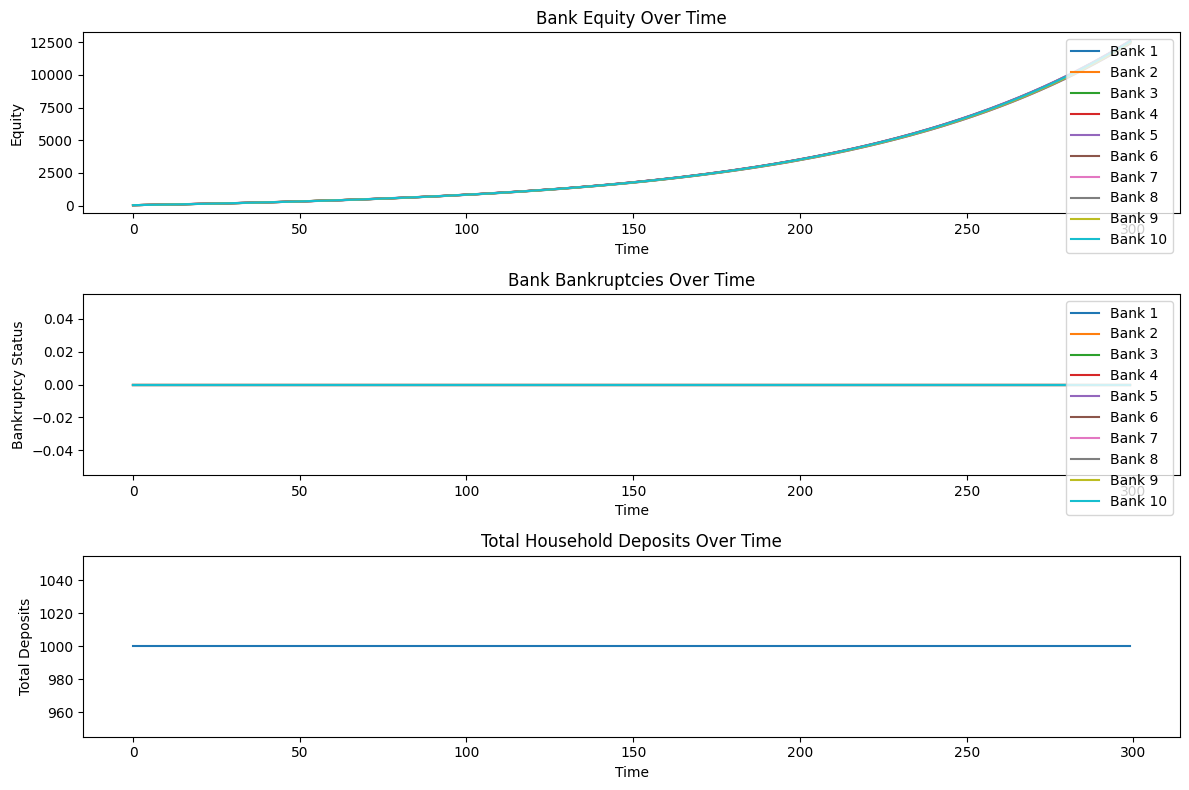

C:\Users\DELL\AppData\Local\Temp\ipykernel_17568\568694205.py:143: RuntimeWarning: divide by zero encountered in divide
  for m in np.where((banks['equity'][p] / banks['risk_weighted_assets'][p]) < CAR)[0]:


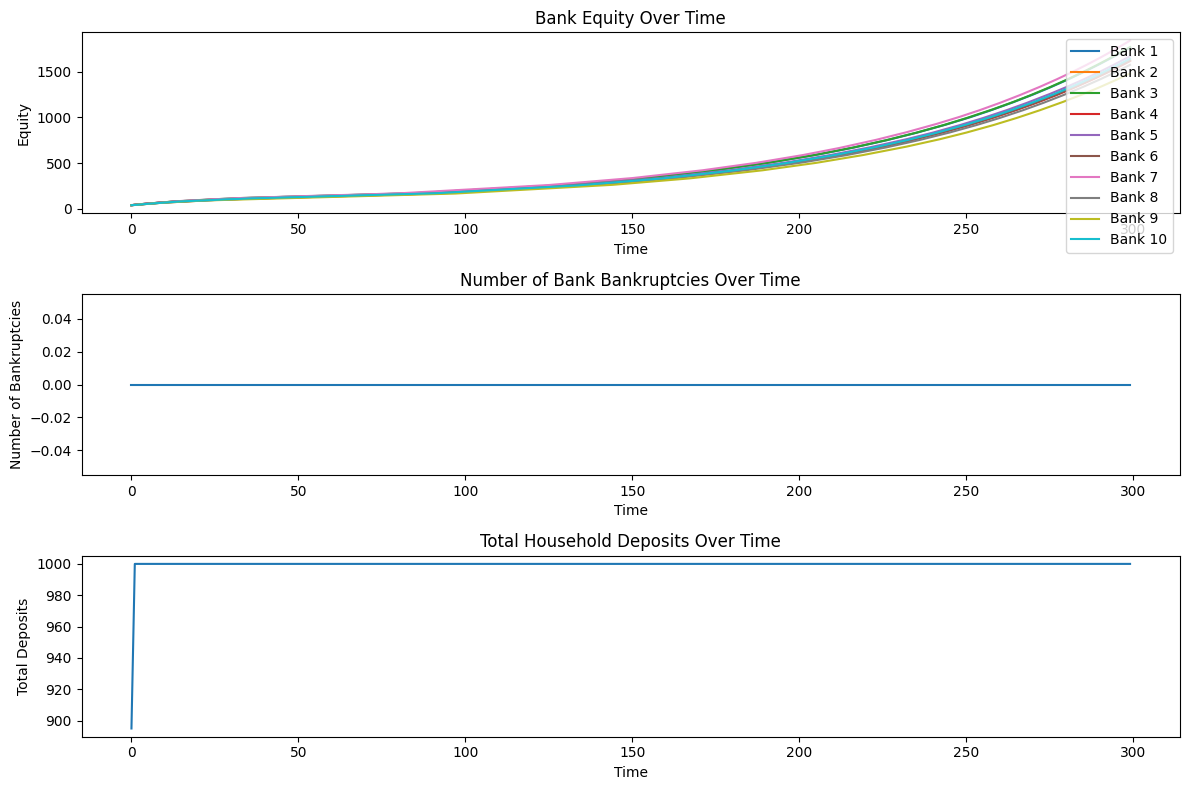

C:\Users\DELL\AppData\Local\Temp\ipykernel_17568\1570255302.py:145: RuntimeWarning: divide by zero encountered in divide
  for m in np.where((banks['equity'][p] / banks['risk_weighted_assets'][p]) < CAR)[0]:


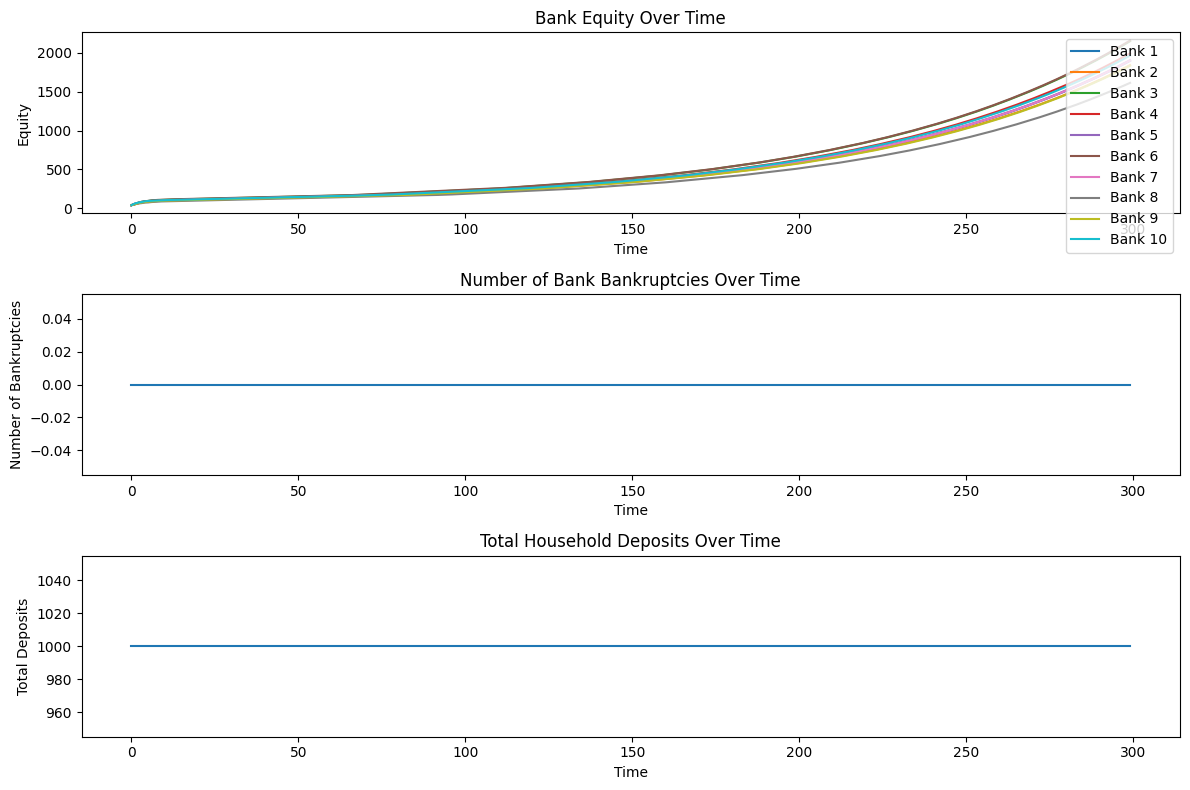

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
t = 300
n_banks = 10
n_households = 1000
n_borrowers = 2000
loan_periods = 1
equity = 40
interest = 0.0125
CAR = 0.08
MRR = 0.035
depo_margin = 0.1
loan_margin = 0.9
recovery_rate = 0.4
withdrawal_prob_min = 0.01
withdrawal_prob_max = 0.2
default_prob_min = 0.02
default_prob_max = 0.5
reserve_fire_sell = 0.8
bankruptcy_fire_sell = 0.5
income_tax = 0.18
target_reserves = 2
u_bound_CAR = 2
safety_effect = 0.04

# Functions
def risk_weight(x):
    return 0.5 + 5 * x

# Agent matrices
households = {
    "depo_value": np.ones((t, n_households)),
    "which_bank": np.random.choice(n_banks, (t, n_households)) + 1,
    "withdrawal_prob": np.tile(np.random.uniform(withdrawal_prob_min, withdrawal_prob_max, n_households), (t, 1))
}

borrowers = {
    "loan_value": np.zeros((t, n_borrowers)),
    "which_bank": np.random.choice(n_banks, (t, n_borrowers)) + 1,
    "pd": np.random.uniform(default_prob_min, default_prob_max, (t, n_borrowers)),
    "recovery_rate": np.full((t, n_borrowers), recovery_rate),
    "cost_capital": np.zeros((t, n_borrowers)),
    "risk_weight": risk_weight(np.random.uniform(default_prob_min, default_prob_max, (t, n_borrowers))),
    "loan_end": np.random.choice(loan_periods, (t, n_borrowers)) + 1
}

banks = {
    "equity": np.full((t, n_banks), equity),
    "sum_deposits": np.zeros((t, n_banks)),
    "loan_portfolio": np.zeros((t, n_banks)),
    "reserves": np.zeros((t, n_banks)),
    "exp_loss_provision": np.zeros((t, n_banks)),
    "revenue": np.zeros((t, n_banks)),
    "cost": np.zeros((t, n_banks)),
    "income": np.zeros((t, n_banks)),
    "risk_weighted_assets": np.zeros((t, n_banks)),
    "dividends": np.zeros((t, n_banks)),
    "liquidity_assistance": np.zeros((t, n_banks)),
    "bankruptcy": np.zeros((t, n_banks)),
    "undercapitalized": np.zeros((t, n_banks))
}

# Initialize values
for w in range(n_banks):
    banks['sum_deposits'][0, w] = np.sum(households['depo_value'][0, households['which_bank'][0] == w + 1])  #sum of the deposits, from one to the w-th household
    RW_assets = borrowers['risk_weight'][0, borrowers['which_bank'][0] == w + 1] #collecting all the risk weights for the deposits (assets) and loans
    potential_loans = int(np.floor(min(banks['sum_deposits'][0, w] * (1 - MRR), np.sum(np.cumsum(RW_assets * CAR) < equity))))
    loan_indices = np.where(borrowers['which_bank'][0] == w + 1)[0]
    borrowers['loan_value'][0, loan_indices[:potential_loans - 5]] = 1
    np.random.shuffle(borrowers['loan_value'][0, loan_indices])
    banks['loan_portfolio'][0, w] = np.sum(borrowers['loan_value'][0, loan_indices])
    banks['risk_weighted_assets'][0, w] = np.sum(borrowers['risk_weight'][0, loan_indices] * borrowers['loan_value'][0, loan_indices])
    banks['exp_loss_provision'][0, w] = np.sum(borrowers['pd'][0, loan_indices] * borrowers['loan_value'][0, loan_indices] * (1 - recovery_rate))
banks["reserves"][0] = banks["sum_deposits"][0] - banks["loan_portfolio"][0]



# Simulation
for p in range(1, t):
    # Update deposits
    for u in range(n_households):
        if np.random.rand() < households['withdrawal_prob'][0, u] + safety_effect * (banks['income'][p-1, int(households['which_bank'][p-1, u])-1] < 0):
            non_bankrupt_banks = np.where(banks['bankruptcy'][p-1] == 0)[0] + 1
            if len(non_bankrupt_banks) > 0:
                households['which_bank'][p, u] = np.random.choice(non_bankrupt_banks)
            else:
                households['which_bank'][p, u] = households['which_bank'][p-1, u]
        else:
            households['which_bank'][p, u] = households['which_bank'][p-1, u]
    households['depo_value'][p] = households['depo_value'][p-1]
    for e in range(n_banks):
        if banks['bankruptcy'][p-1, e] == 0:
            banks['sum_deposits'][p, e] = np.sum(households['depo_value'][p, households['which_bank'][p] == e + 1])
        else:
            banks['sum_deposits'][p, e] = 0

    # Update loans
    borrowers['loan_value'][p] = borrowers['loan_value'][p-1]
    defaults = np.random.rand(n_borrowers) < borrowers['pd'][p]
    borrowers['loan_value'][p, defaults] = 0
    for r in range(n_banks):
        if banks['bankruptcy'][p-1, r] == 0:
            loan_indices = np.where(borrowers['which_bank'][p] == r + 1)[0]
            banks['loan_portfolio'][p, r] = np.sum(borrowers['loan_value'][p, loan_indices])
            banks['exp_loss_provision'][p, r] = np.sum(borrowers['pd'][p, loan_indices] * borrowers['loan_value'][p, loan_indices] * (1 - recovery_rate))
    banks['reserves'][p] = banks['sum_deposits'][p] - banks['loan_portfolio'][p] + banks['equity'][p-1]

    # Sell loans if reserves are insufficient
    reserve_shortfall = banks['sum_deposits'][p] * MRR - banks['reserves'][p]
    for d in np.where(reserve_shortfall > 0)[0]:
        if banks['bankruptcy'][p-1, d] == 0:
            sell_amount = int(np.ceil(reserve_shortfall[d] / reserve_fire_sell))
            loan_indices = np.where((borrowers['which_bank'][p] == d + 1) & (borrowers['loan_value'][p] == 1))[0]
            borrowers['loan_value'][p, loan_indices[:sell_amount]] = 0
            banks['reserves'][p, d] += sell_amount * reserve_fire_sell
    banks['reserves'][p] = banks['sum_deposits'][p] - banks['loan_portfolio'][p] + banks['equity'][p-1]

    # Calculate revenue and costs
    for y in range(n_banks):
        if banks['bankruptcy'][p-1, y] == 0:
            loan_indices = np.where(borrowers['which_bank'][p] == y + 1)[0]
            borrowers['cost_capital'][p, loan_indices] = ((1 + (loan_margin + 1) * interest) - borrowers['pd'][p, loan_indices] * recovery_rate) / (1 - borrowers['pd'][p, loan_indices])
            banks['revenue'][p, y] = np.sum(borrowers['cost_capital'][p, loan_indices] * borrowers['loan_value'][p, loan_indices]) - np.sum(borrowers['loan_value'][p, loan_indices])
            banks['revenue'][p, y] += banks['reserves'][p-1, y] * interest
            banks['cost'][p, y] = np.sum(households['depo_value'][p, households['which_bank'][p] == y + 1] * interest * (1 + depo_margin))
    banks['income'][p] = banks['revenue'][p] - banks['cost'][p]
    banks['equity'][p] = banks['equity'][p-1] + banks['income'][p]

    # Check for bankruptcy and update deposits and loans
    for k in np.where(banks['equity'][p] < 0)[0]:
        banks['bankruptcy'][p, k] = 1
        banks['equity'][p:, k] = 0  # Updated to zero from current time step onwards
        banks['sum_deposits'][p:, k] = 0  # Updated to zero from current time step onwards
        banks['loan_portfolio'][p:, k] = 0  # Updated to zero from current time step onwards
        loan_indices = np.where(borrowers['which_bank'][p] == k + 1)[0]
        borrowers['loan_value'][p, loan_indices] = 0  # Updated to zero from current time step onwards
        banks['exp_loss_provision'][p:, k] = 0  # Updated to zero from current time step onwards
        non_bankrupt_banks = np.where(banks['bankruptcy'][p-1] == 0)[0] + 1
        if len(non_bankrupt_banks) > 0:
            households['which_bank'][p, households['which_bank'][p] == k + 1] = np.random.choice(non_bankrupt_banks, np.sum(households['which_bank'][p] == k + 1))

    # Check for undercapitalized banks
    for m in np.where((banks['equity'][p] / banks['risk_weighted_assets'][p]) < CAR)[0]:
        banks['undercapitalized'][p, m] = 1

# Visualization
time_steps = np.arange(t)

plt.figure(figsize=(12, 8))

# Plot bank equity
plt.subplot(3, 1, 1)
for i in range(n_banks):
    plt.plot(time_steps, banks['equity'][:, i], label=f'Bank {i+1}')
plt.title('Bank Equity Over Time')
plt.xlabel('Time')
plt.ylabel('Equity')
plt.legend()

# Plot number of bankrupt banks over time
plt.subplot(3, 1, 2)
bankruptcies_over_time = np.sum(banks['bankruptcy'], axis=1)
plt.plot(time_steps, bankruptcies_over_time)
plt.title('Number of Bank Bankruptcies Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Bankruptcies')

# Plot total household deposits
plt.subplot(3, 1, 3)
total_deposits = np.sum(banks['sum_deposits'], axis=1)
plt.plot(time_steps, total_deposits)
plt.title('Total Household Deposits Over Time')
plt.xlabel('Time')
plt.ylabel('Total Deposits')

plt.tight_layout()
plt.show()


In [78]:
banks['exp_loss_provision']

array([[13.61818024, 14.17495144, 13.7615992 , ..., 13.09017079,
        13.68020828, 12.17243992],
       [ 8.94386443,  8.7932185 , 11.52347562, ...,  7.02258541,
         7.37311076, 12.31502333],
       [10.20742476,  5.98178213,  7.58587666, ...,  6.11779565,
         8.56772669,  6.80729899],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [79]:
banks['sum_deposits']

array([[ 95.,  87., 100., ..., 101., 101.,  90.],
       [101.,  91.,  98., ...,  97., 103.,  87.],
       [ 97.,  97.,  96., ..., 100., 102.,  92.],
       ...,
       [110., 103., 110., ...,  85.,  91., 106.],
       [105., 107., 110., ...,  85.,  89., 100.],
       [102., 108., 113., ...,  86.,  96., 100.]])

In [80]:
np.where(reserve_shortfall > 0)[0]

array([], dtype=int64)

In [81]:
borrowers['loan_value'][:, -10:]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [82]:
households

{'depo_value': array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]),
 'which_bank': array([[ 2,  8,  4, ..., 10,  9,  5],
        [ 2,  8,  4, ..., 10,  9,  5],
        [ 2,  8,  4, ..., 10,  9,  5],
        ...,
        [ 6,  4,  1, ...,  7,  1,  1],
        [ 6, 10,  1, ...,  7,  1,  1],
        [ 6, 10,  1, ...,  7,  1,  1]]),
 'withdrawal_prob': array([[0.03251962, 0.03915315, 0.04508157, ..., 0.16078519, 0.13634031,
         0.10175111],
        [0.03251962, 0.03915315, 0.04508157, ..., 0.16078519, 0.13634031,
         0.10175111],
        [0.03251962, 0.03915315, 0.04508157, ..., 0.16078519, 0.13634031,
         0.10175111],
        ...,
        [0.03251962, 0.03915315, 0.04508157, ..., 0.16078519, 0.13634031,
         0.10175111],
        [0.03251962, 0.03915315, 0.04508157, ..., 0.160785

In [83]:
banks

{'equity': array([[  40,   40,   40, ...,   40,   40,   40],
        [  53,   53,   58, ...,   51,   51,   61],
        [  70,   63,   70, ...,   61,   65,   72],
        ...,
        [1854, 1800, 2101, ..., 1577, 1792, 1921],
        [1876, 1822, 2126, ..., 1596, 1814, 1944],
        [1899, 1844, 2152, ..., 1615, 1836, 1967]]),
 'sum_deposits': array([[ 95.,  87., 100., ..., 101., 101.,  90.],
        [101.,  91.,  98., ...,  97., 103.,  87.],
        [ 97.,  97.,  96., ..., 100., 102.,  92.],
        ...,
        [110., 103., 110., ...,  85.,  91., 106.],
        [105., 107., 110., ...,  85.,  89., 100.],
        [102., 108., 113., ...,  86.,  96., 100.]]),
 'loan_portfolio': array([[86., 78., 91., ..., 92., 92., 81.],
        [66., 65., 85., ..., 51., 53., 78.],
        [63., 40., 48., ..., 45., 62., 45.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 'reserves': array([[   9.,  

In [84]:
borrowers

{'loan_value': array([[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'which_bank': array([[ 8,  9, 10, ...,  6,  3,  9],
        [ 9,  5,  5, ...,  2,  2,  8],
        [ 7, 10, 10, ...,  8,  6,  7],
        ...,
        [ 8,  7,  2, ...,  8,  5,  7],
        [ 9,  9,  1, ...,  4,  4,  1],
        [ 3,  5,  5, ..., 10,  9,  8]]),
 'pd': array([[0.32272103, 0.05969404, 0.48607741, ..., 0.31928157, 0.22711008,
         0.08822236],
        [0.08469013, 0.031377  , 0.30243028, ..., 0.28110763, 0.22438473,
         0.31360293],
        [0.22958078, 0.4074885 , 0.15896599, ..., 0.27170835, 0.41508755,
         0.48918607],
        ...,
        [0.21738357, 0.12924238, 0.27449761, ..., 0.32442499, 0.11728269,
         0.33537171],
        [0.08905303, 0.34801981, 0.04036545, ..., 0.23763363, 0.3205172

C:\Users\DELL\AppData\Local\Temp\ipykernel_17568\772618374.py:131: RuntimeWarning: divide by zero encountered in divide
  for k in np.where((banks['equity'][p] / banks['risk_weighted_assets'][p]) < CAR)[0]:
C:\Users\DELL\AppData\Local\Temp\ipykernel_17568\772618374.py:145: RuntimeWarning: divide by zero encountered in divide
  for m in np.where((banks['equity'][p] / banks['risk_weighted_assets'][p]) < CAR)[0]:


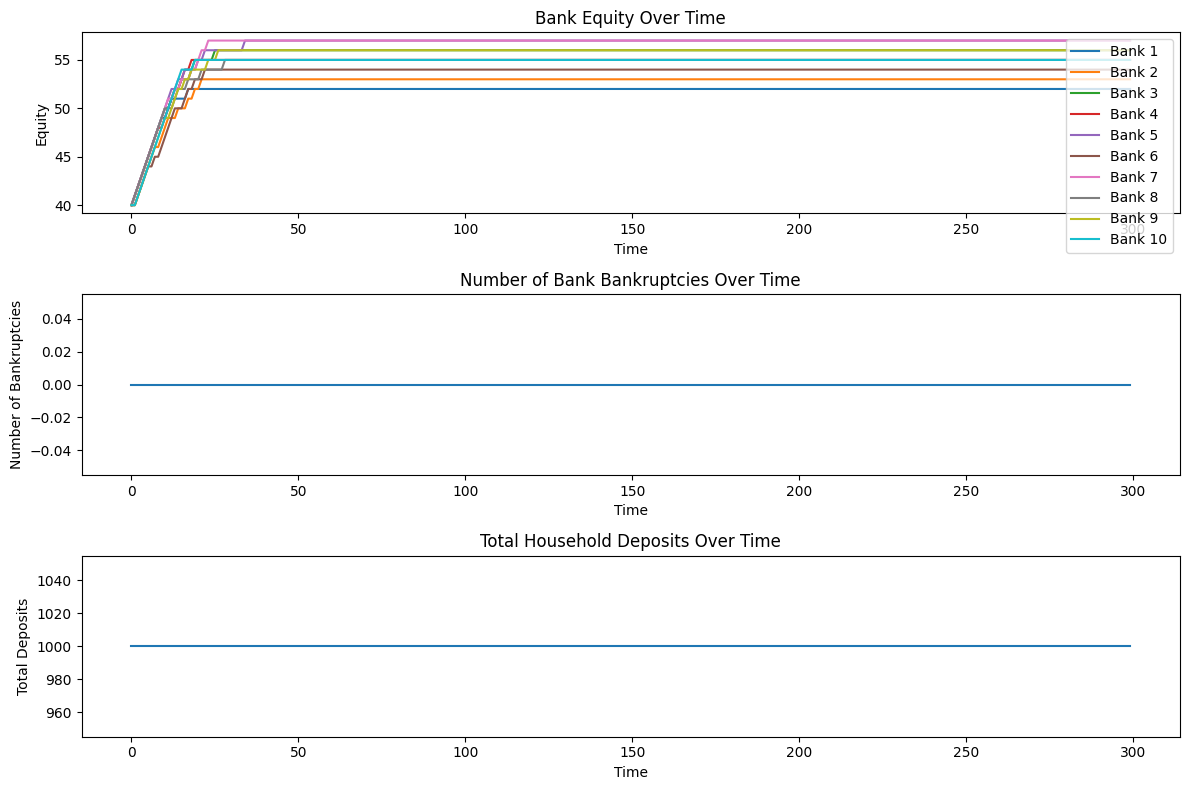

In [85]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
t = 300
n_banks = 10
n_households = 1000
n_borrowers = 2000
loan_periods = 1
equity = 40
interest = 0.0125
CAR = 0.08
MRR = 0.035
depo_margin = 0.1
loan_margin = 0.9
recovery_rate = 0.4
withdrawal_prob_min = 0.01
withdrawal_prob_max = 0.08
default_prob_min = 0.04
default_prob_max = 0.08
reserve_fire_sell = 0.8
bankruptcy_fire_sell = 0.5
income_tax = 0.18
target_reserves = 2
u_bound_CAR = 2
safety_effect = 0.04

# Functions
def risk_weight(x):
    return 0.5 + 5 * x

# Agent matrices
households = {
    "depo_value": np.ones((t, n_households)),
    "which_bank": np.random.choice(n_banks, (t, n_households)) + 1,
    "withdrawal_prob": np.tile(np.random.uniform(withdrawal_prob_min, withdrawal_prob_max, n_households), (t, 1))
}

borrowers = {
    "loan_value": np.zeros((t, n_borrowers)),
    "which_bank": np.random.choice(n_banks, (t, n_borrowers)) + 1,
    "pd": np.random.uniform(default_prob_min, default_prob_max, (t, n_borrowers)),
    "recovery_rate": np.full((t, n_borrowers), recovery_rate),
    "cost_capital": np.zeros((t, n_borrowers)),
    "risk_weight": risk_weight(np.random.uniform(default_prob_min, default_prob_max, (t, n_borrowers))),
    "loan_end": np.random.choice(loan_periods, (t, n_borrowers)) + 1
}

banks = {
    "equity": np.full((t, n_banks), equity),
    "sum_deposits": np.zeros((t, n_banks)),
    "loan_portfolio": np.zeros((t, n_banks)),
    "reserves": np.zeros((t, n_banks)),
    "exp_loss_provision": np.zeros((t, n_banks)),
    "revenue": np.zeros((t, n_banks)),
    "cost": np.zeros((t, n_banks)),
    "income": np.zeros((t, n_banks)),
    "risk_weighted_assets": np.zeros((t, n_banks)),
    "dividends": np.zeros((t, n_banks)),
    "liquidity_assistance": np.zeros((t, n_banks)),
    "bankruptcy": np.zeros((t, n_banks)),
    "undercapitalized": np.zeros((t, n_banks))
}

# Initialize values
for w in range(n_banks):
    banks['sum_deposits'][0, w] = np.sum(households['depo_value'][0, households['which_bank'][0] == w + 1])
    RW_assets = borrowers['risk_weight'][0, borrowers['which_bank'][0] == w + 1]
    potential_loans = int(np.floor(min(banks['sum_deposits'][0, w] * (1 - MRR), np.sum(np.cumsum(RW_assets * CAR) < equity))))
    loan_indices = np.where(borrowers['which_bank'][0] == w + 1)[0]
    borrowers['loan_value'][0, loan_indices[:potential_loans - 5]] = 1
    np.random.shuffle(borrowers['loan_value'][0, loan_indices])
    banks['loan_portfolio'][0, w] = np.sum(borrowers['loan_value'][0, loan_indices])
    banks['risk_weighted_assets'][0, w] = np.sum(borrowers['risk_weight'][0, loan_indices] * borrowers['loan_value'][0, loan_indices])
    banks['exp_loss_provision'][0, w] = np.sum(borrowers['pd'][0, loan_indices] * borrowers['loan_value'][0, loan_indices] * (1 - recovery_rate))
banks["reserves"][0] = banks["sum_deposits"][0] - banks["loan_portfolio"][0]

# Simulation
for p in range(1, t):
    # Update deposits
    for u in range(n_households):
        if np.random.rand() < households['withdrawal_prob'][0, u] + safety_effect * (banks['income'][p-1, int(households['which_bank'][p-1, u])-1] < 0):
            non_bankrupt_banks = np.where(banks['bankruptcy'][p-1] == 0)[0] + 1
            if len(non_bankrupt_banks) > 0:
                households['which_bank'][p, u] = np.random.choice(non_bankrupt_banks)
            else:
                households['which_bank'][p, u] = households['which_bank'][p-1, u]
        else:
            households['which_bank'][p, u] = households['which_bank'][p-1, u]
    households['depo_value'][p] = households['depo_value'][p-1]
    for e in range(n_banks):
        if banks['bankruptcy'][p-1, e] == 0:
            banks['sum_deposits'][p, e] = np.sum(households['depo_value'][p, households['which_bank'][p] == e + 1])
        else:
            banks['sum_deposits'][p, e] = 0

    # Update loans
    borrowers['loan_value'][p] = borrowers['loan_value'][p-1]
    defaults = np.random.rand(n_borrowers) < borrowers['pd'][p]
    borrowers['loan_value'][p, defaults] = 0
    for r in range(n_banks):
        if banks['bankruptcy'][p-1, r] == 0:
            loan_indices = np.where(borrowers['which_bank'][p] == r + 1)[0]
            banks['loan_portfolio'][p, r] = np.sum(borrowers['loan_value'][p, loan_indices])
            banks['exp_loss_provision'][p, r] = np.sum(borrowers['pd'][p, loan_indices] * borrowers['loan_value'][p, loan_indices] * (1 - recovery_rate))
    banks['reserves'][p] = banks['sum_deposits'][p] - banks['loan_portfolio'][p] + banks['equity'][p-1]

    # Sell loans if reserves are insufficient
    reserve_shortfall = banks['sum_deposits'][p] * MRR - banks['reserves'][p]
    for d in np.where(reserve_shortfall > 0)[0]:
        if banks['bankruptcy'][p-1, d] == 0:
            sell_amount = int(np.ceil(reserve_shortfall[d] / reserve_fire_sell))
            loan_indices = np.where((borrowers['which_bank'][p] == d + 1) & (borrowers['loan_value'][p] == 1))[0]
            borrowers['loan_value'][p, loan_indices[:sell_amount]] = 0
            banks['reserves'][p, d] += sell_amount * reserve_fire_sell
    banks['reserves'][p] = banks['sum_deposits'][p] - banks['loan_portfolio'][p] + banks['equity'][p-1]

    # Calculate revenue and costs
    for y in range(n_banks):
        if banks['bankruptcy'][p-1, y] == 0:
            loan_indices = np.where(borrowers['which_bank'][p] == y + 1)[0]
            borrowers['cost_capital'][p, loan_indices] = ((1 + (loan_margin + 1) * interest) - borrowers['pd'][p, loan_indices] * recovery_rate) / (1 - borrowers['pd'][p, loan_indices])
            banks['revenue'][p, y] = np.sum(borrowers['cost_capital'][p, loan_indices] * borrowers['loan_value'][p, loan_indices]) - np.sum(borrowers['loan_value'][p, loan_indices])
            banks['revenue'][p, y] += banks['reserves'][p-1, y] * interest
            banks['cost'][p, y] = np.sum(households['depo_value'][p, households['which_bank'][p] == y + 1] * interest * (1 + depo_margin))
    banks['income'][p] = banks['revenue'][p] - banks['cost'][p]
    banks['equity'][p] = banks['equity'][p-1] + banks['income'][p] - banks['exp_loss_provision'][p] - banks['dividends'][p-1]
    banks['reserves'][p] = banks['sum_deposits'][p] - banks['loan_portfolio'][p] + banks['equity'][p]

    # Check for bankrupt banks
    for k in np.where((banks['equity'][p] / banks['risk_weighted_assets'][p]) < CAR)[0]:
        banks['bankruptcy'][p, k] = 1
        banks['equity'][p, k] = 0
        banks['reserves'][p, k] = 0
        banks['sum_deposits'][p, k] = 0  # Updated to zero from current time step onwards
        banks['loan_portfolio'][p, k] = 0  # Updated to zero from current time step onwards
        loan_indices = np.where(borrowers['which_bank'][p] == k + 1)[0]
        borrowers['loan_value'][p, loan_indices] = 0  # Updated to zero from current time step onwards
        banks['exp_loss_provision'][p, k] = 0  # Updated to zero from current time step onwards
        non_bankrupt_banks = np.where(banks['bankruptcy'][p-1] == 0)[0] + 1
        if len(non_bankrupt_banks) > 0:
            households['which_bank'][p, households['which_bank'][p] == k + 1] = np.random.choice(non_bankrupt_banks, np.sum(households['which_bank'][p] == k + 1))

    # Check for undercapitalized banks
    for m in np.where((banks['equity'][p] / banks['risk_weighted_assets'][p]) < CAR)[0]:
        banks['undercapitalized'][p, m] = 1

# Visualization
time_steps = np.arange(t)

plt.figure(figsize=(12, 8))

# Plot bank equity
plt.subplot(3, 1, 1)
for i in range(n_banks):
    plt.plot(time_steps, banks['equity'][:, i], label=f'Bank {i+1}')
plt.title('Bank Equity Over Time')
plt.xlabel('Time')
plt.ylabel('Equity')
plt.legend()

# Plot number of bankrupt banks over time
plt.subplot(3, 1, 2)
bankruptcies_over_time = np.sum(banks['bankruptcy'], axis=1)
plt.plot(time_steps, bankruptcies_over_time)
plt.title('Number of Bank Bankruptcies Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Bankruptcies')

# Plot total household deposits
plt.subplot(3, 1, 3)
total_deposits = np.sum(banks['sum_deposits'], axis=1)
plt.plot(time_steps, total_deposits)
plt.title('Total Household Deposits Over Time')
plt.xlabel('Time')
plt.ylabel('Total Deposits')

plt.tight_layout()
plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_17568\1516646795.py:146: RuntimeWarning: divide by zero encountered in divide
  for k in np.where((banks['equity'][p] / banks['risk_weighted_assets'][p]) < CAR)[0]:
C:\Users\DELL\AppData\Local\Temp\ipykernel_17568\1516646795.py:159: RuntimeWarning: divide by zero encountered in divide
  for m in np.where((banks['equity'][p] / banks['risk_weighted_assets'][p]) < CAR)[0]:
C:\Users\DELL\AppData\Local\Temp\ipykernel_17568\1516646795.py:146: RuntimeWarning: invalid value encountered in divide
  for k in np.where((banks['equity'][p] / banks['risk_weighted_assets'][p]) < CAR)[0]:
C:\Users\DELL\AppData\Local\Temp\ipykernel_17568\1516646795.py:159: RuntimeWarning: invalid value encountered in divide
  for m in np.where((banks['equity'][p] / banks['risk_weighted_assets'][p]) < CAR)[0]:


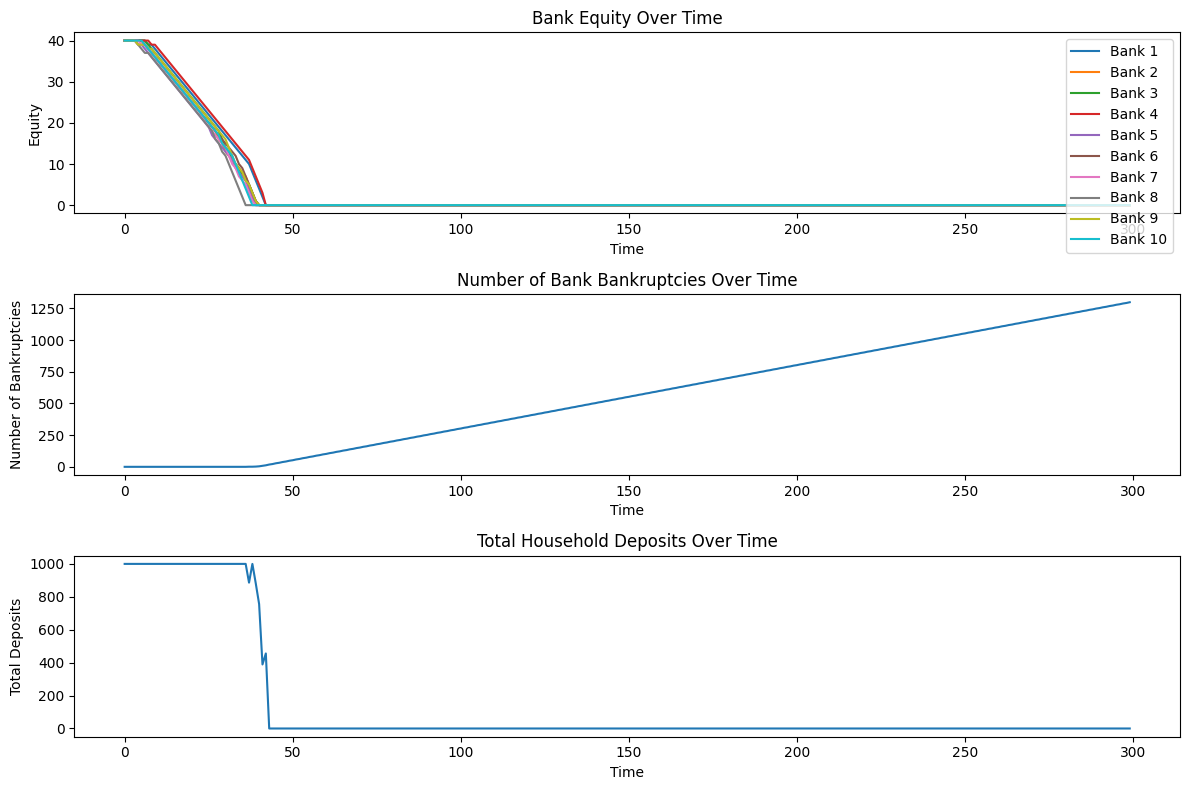

NameError: name 'lfliwflwi' is not defined

In [88]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
t = 300  # Number of time periods
n_banks = 10  # Number of banks
n_households = 1000  # Number of households
n_borrowers = 2000  # Number of borrowers
loan_periods = 1  # Loan periods (constant in this case)
equity = 40  # Initial equity
interest = 0.0125  # Interest rate
CAR = 0.08  # Capital Adequacy Ratio
MRR = 0.035  # Minimum Reserve Requirement
depo_margin = 0.1  # Deposit margin
loan_margin = 0.9  # Loan margin
recovery_rate = 0.4  # Recovery rate
withdrawal_prob_min = 0.01  # Min withdrawal probability
withdrawal_prob_max = 0.08  # Max withdrawal probability
default_prob_min = 0.04  # Min default probability
default_prob_max = 0.08  # Max default probability
reserve_fire_sell = 0.8  # Reserve fire sale value
bankruptcy_fire_sell = 0.5  # Bankruptcy fire sale value
income_tax = 0.18  # Income tax rate
target_reserves = 2  # Target reserves
u_bound_CAR = 2  # Upper bound CAR
safety_effect = 0.04  # Safety effect on withdrawal probability

# Functions
def risk_weight(x):
    return 0.5 + 5 * x

# Agent matrices
households = {
    "depo_value": np.ones((t, n_households)),
    "which_bank": np.random.choice(n_banks, (t, n_households)) + 1,
    "withdrawal_prob": np.tile(np.random.uniform(withdrawal_prob_min, withdrawal_prob_max, n_households), (t, 1))
}

borrowers = {
    "loan_value": np.zeros((t, n_borrowers)),
    "which_bank": np.random.choice(n_banks, (t, n_borrowers)) + 1,
    "pd": np.random.uniform(default_prob_min, default_prob_max, (t, n_borrowers)),
    "recovery_rate": np.full((t, n_borrowers), recovery_rate),
    "cost_capital": np.zeros((t, n_borrowers)),
    "risk_weight": risk_weight(np.random.uniform(default_prob_min, default_prob_max, (t, n_borrowers))),
    "loan_end": np.random.choice(loan_periods, (t, n_borrowers)) + 1
}

banks = {
    "equity": np.full((t, n_banks), equity),
    "sum_deposits": np.zeros((t, n_banks)),
    "loan_portfolio": np.zeros((t, n_banks)),
    "reserves": np.zeros((t, n_banks)),
    "exp_loss_provision": np.zeros((t, n_banks)),
    "revenue": np.zeros((t, n_banks)),
    "cost": np.zeros((t, n_banks)),
    "income": np.zeros((t, n_banks)),
    "risk_weighted_assets": np.zeros((t, n_banks)),
    "dividends": np.zeros((t, n_banks)),
    "liquidity_assistance": np.zeros((t, n_banks)),
    "bankruptcy": np.zeros((t, n_banks)),
    "undercapitalized": np.zeros((t, n_banks))
}

# Initialize values
for w in range(n_banks):
    banks['sum_deposits'][0, w] = np.sum(households['depo_value'][0, households['which_bank'][0] == w + 1])
    RW_assets = borrowers['risk_weight'][0, borrowers['which_bank'][0] == w + 1]
    potential_loans = int(np.floor(min(banks['sum_deposits'][0, w] * (1 - MRR), np.sum(np.cumsum(RW_assets * CAR) < equity))))
    loan_indices = np.where(borrowers['which_bank'][0] == w + 1)[0]
    borrowers['loan_value'][0, loan_indices[:potential_loans - 5]] = 1
    np.random.shuffle(borrowers['loan_value'][0, loan_indices])
    banks['loan_portfolio'][0, w] = np.sum(borrowers['loan_value'][0, loan_indices])
    banks['risk_weighted_assets'][0, w] = np.sum(borrowers['risk_weight'][0, loan_indices] * borrowers['loan_value'][0, loan_indices])
    banks['exp_loss_provision'][0, w] = np.sum(borrowers['pd'][0, loan_indices] * borrowers['loan_value'][0, loan_indices] * (1 - recovery_rate))
banks["reserves"][0] = banks["sum_deposits"][0] - banks["loan_portfolio"][0]

# Simulation
for p in range(1, t):
    # Update deposits
    for u in range(n_households):
        if np.random.rand() < households['withdrawal_prob'][0, u] + safety_effect * (banks['income'][p-1, int(households['which_bank'][p-1, u])-1] < 0):
            non_bankrupt_banks = np.where(banks['bankruptcy'][p-1] == 0)[0] + 1
            if len(non_bankrupt_banks) > 0:
                households['which_bank'][p, u] = np.random.choice(non_bankrupt_banks)
            else:
                households['which_bank'][p, u] = households['which_bank'][p-1, u]
        else:
            households['which_bank'][p, u] = households['which_bank'][p-1, u]
    households['depo_value'][p] = households['depo_value'][p-1]
    for e in range(n_banks):
        if banks['bankruptcy'][p-1, e] == 0:
            banks['sum_deposits'][p, e] = np.sum(households['depo_value'][p, households['which_bank'][p] == e + 1])
        else:
            banks['sum_deposits'][p, e] = 0

    # Update loans
    borrowers['loan_value'][p] = borrowers['loan_value'][p-1]
    defaults = np.random.rand(n_borrowers) < borrowers['pd'][p]
    borrowers['loan_value'][p, defaults] = 0
    for r in range(n_banks):
        if banks['bankruptcy'][p-1, r] == 0:
            loan_indices = np.where(borrowers['which_bank'][p] == r + 1)[0]
            banks['loan_portfolio'][p, r] = np.sum(borrowers['loan_value'][p, loan_indices])
            banks['exp_loss_provision'][p, r] = np.sum(borrowers['pd'][p, loan_indices] * borrowers['loan_value'][p, loan_indices] * (1 - recovery_rate))
    banks['reserves'][p] = banks['sum_deposits'][p] - banks['loan_portfolio'][p] + banks['equity'][p-1]

    # Sell loans if reserves are insufficient
    reserve_shortfall = banks['sum_deposits'][p] * MRR - banks['reserves'][p]
    for d in np.where(reserve_shortfall > 0)[0]:
        if banks['bankruptcy'][p-1, d] == 0:
            sell_amount = int(np.ceil(reserve_shortfall[d] / reserve_fire_sell))
            loan_indices = np.where((borrowers['which_bank'][p] == d + 1) & (borrowers['loan_value'][p] == 1))[0]
            borrowers['loan_value'][p, loan_indices[:sell_amount]] = 0
            banks['reserves'][p, d] += sell_amount * reserve_fire_sell
    banks['reserves'][p] = banks['sum_deposits'][p] - banks['loan_portfolio'][p] + banks['equity'][p-1]

    # Calculate revenue and costs
    for y in range(n_banks):
        if banks['bankruptcy'][p-1, y] == 0:
            loan_indices = np.where(borrowers['which_bank'][p] == y + 1)[0]
            borrowers['cost_capital'][p, loan_indices] = ((1 + (loan_margin + 1) * interest) - borrowers['pd'][p, loan_indices] * recovery_rate) / (1 - borrowers['pd'][p, loan_indices])
            banks['revenue'][p, y] = np.sum(borrowers['cost_capital'][p, loan_indices] * borrowers['loan_value'][p, loan_indices]) - np.sum(borrowers['loan_value'][p, loan_indices])
            banks['cost'][p, y] = interest * banks['sum_deposits'][p, y]
            banks['income'][p, y] = banks['revenue'][p, y] - banks['cost'][p, y]

            if banks['income'][p, y] > 0:
                banks['dividends'][p, y] = income_tax * banks['income'][p, y]
            else:
                banks['dividends'][p, y] = 0

            banks['equity'][p, y] = banks['equity'][p-1, y] + banks['income'][p, y] - banks['exp_loss_provision'][p, y] - banks['dividends'][p, y]
            banks['reserves'][p, y] = banks['sum_deposits'][p, y] - banks['loan_portfolio'][p, y] + banks['equity'][p, y]
        else:
            banks['equity'][p, y] = 0
            banks['reserves'][p, y] = 0
            banks['sum_deposits'][p, y] = 0
            banks['loan_portfolio'][p, y] = 0
            banks['exp_loss_provision'][p, y] = 0
            banks['dividends'][p, y] = 0
            banks['income'][p, y] = 0
            banks['revenue'][p, y] = 0
            banks['cost'][p, y] = 0

    # Check for bankrupt banks
    for k in np.where((banks['equity'][p] / banks['risk_weighted_assets'][p]) < CAR)[0]:
        banks['bankruptcy'][p, k] = 1
        banks['equity'][p, k] = 0
        banks['reserves'][p, k] = 0
        banks['sum_deposits'][p, k] = 0
        banks['loan_portfolio'][p, k] = 0
        loan_indices = np.where(borrowers['which_bank'][p] == k + 1)[0]
        borrowers['loan_value'][p, loan_indices] = 0
        non_bankrupt_banks = np.where(banks['bankruptcy'][p] == 0)[0] + 1
        if len(non_bankrupt_banks) > 0:
            households['which_bank'][p, households['which_bank'][p] == k + 1] = np.random.choice(non_bankrupt_banks, np.sum(households['which_bank'][p] == k + 1))

    # Check for undercapitalized banks
    for m in np.where((banks['equity'][p] / banks['risk_weighted_assets'][p]) < CAR)[0]:
        banks['undercapitalized'][p, m] = 1

# Visualization
time_steps = np.arange(t)

plt.figure(figsize=(12, 8))

# Plot bank equity
plt.subplot(3, 1, 1)
for i in range(n_banks):
    plt.plot(time_steps, banks['equity'][:, i], label=f'Bank {i+1}')
plt.title('Bank Equity Over Time')
plt.xlabel('Time')
plt.ylabel('Equity')
plt.legend()

# Plot number of bankrupt banks over time
plt.subplot(3, 1, 2)
bankruptcies_over_time = np.cumsum(np.sum(banks['bankruptcy'], axis=1))
plt.plot(time_steps, bankruptcies_over_time)
plt.title('Number of Bank Bankruptcies Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Bankruptcies')

# Plot total household deposits
plt.subplot(3, 1, 3)
total_deposits = np.sum(banks['sum_deposits'], axis=1)
plt.plot(time_steps, total_deposits)
plt.title('Total Household Deposits Over Time')
plt.xlabel('Time')
plt.ylabel('Total Deposits')

plt.tight_layout()
plt.show()


In [91]:
banks['bankruptcy'][0:10,:]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [92]:
banks['equity']

array([[40, 40, 40, ..., 40, 40, 40],
       [40, 40, 40, ..., 40, 40, 40],
       [40, 40, 40, ..., 40, 40, 40],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])